<a id="top"></a>
# Rubin Microlensing Simulations with PyLIMA & LightCurveLynx

<hr style="border: 1.5pt solid #a859e4; width: 100%; margin-top: -10px;">

A comprehensive tutorial for the RGES-PIT Microlensing Working Group on simulating multi-band microlensing light curves using the **LightCurveLynx** simulation framework with **PyLIMA** models, tailored for **Rubin Observatory / LSST** cadence and photometry.

## Learning Goals

By the end of this notebook you will have learned to:

- Install and configure **LightCurveLynx** with the **PyLIMA** microlensing backend for Rubin/LSST simulations
- Create and customize **observation cadences** (fake OpSim or real Rubin OpSim files)
- Configure **Rubin passbands** (ugrizy) with the built-in LSST preset
- Build **PyLIMA wrapper models** for various microlensing event types (PSPL, FSPL, USBL)
- Define **tunable priors and parameter distributions** for all physical parameters (u0, tE, piEN, piEE, rho, etc.)
- Set **source and blend magnitudes** per filter with full control over blending conventions
- Generate **batches of simulated light curves** with realistic Rubin noise and cadence
- Inspect, plot, and export the simulated data in nested-pandas format

In addition, you'll gain:
- Understanding of how LightCurveLynx orchestrates PyLIMA models under the hood
- Experience tuning priors for different science cases (high-magnification events, planetary signals, finite-source effects)
- Practical skills for building simulation pipelines that scale to thousands of events

## Introduction

This tutorial walks through a complete workflow for simulating microlensing light curves as they would be observed by the **Vera C. Rubin Observatory's Legacy Survey of Space and Time (LSST)**. We use the [LightCurveLynx](https://lightcurvelynx.readthedocs.io/) simulation framework with its [PyLIMA](https://github.com/ebachelet/pyLIMA) wrapper to generate multi-band light curves with realistic cadence, photometry, and noise.

### Why LightCurveLynx + PyLIMA?

**LightCurveLynx** is a general-purpose light curve simulation framework developed by LINCC Frameworks. It handles:
- Survey cadence and observation tables (OpSim)
- Multi-band passband definitions  
- Noise injection based on survey parameters (seeing, sky brightness, exposure time)
- Parallel batch simulation and nested-pandas output

**PyLIMA** is a dedicated microlensing modeling package that provides:
- Accurate microlensing magnification models (PSPL, FSPL, PSBL, USBL, FSBL, and more)
- Parallax effects (annual, terrestrial, and full)
- Finite-source effects with limb darkening
- Binary-lens caustic crossing events

By combining these tools, we get a pipeline where PyLIMA computes the astrophysics and LightCurveLynx handles the survey realism.

### Microlensing Models Covered

| Model | Description | Key Parameters |
|-------|-------------|----------------|
| **PSPL** | Point-Source Point-Lens | $t_0$, $u_0$, $t_E$, $\pi_{E,N}$, $\pi_{E,E}$ |
| **FSPL** | Finite-Source Point-Lens | All PSPL params + $\rho$ (source size) |
| **PSBL** | Point-Source Binary-Lens | $t_0$, $u_0$, $t_E$, $s$, $q$, $\alpha$ |
| **USBL** | Uniform-Source Binary-Lens | All PSBL params + $\rho$ (source size) |
| **FSBL** | Finite-Source Binary-Lens (limb-darkened) | All USBL params + limb-darkening $a_1$ |

### Microlensing Parameter Refresher

A point-source point-lens (PSPL) event is described by:

- **$t_0$** - time of closest approach between the source and lens lines of sight
- **$u_0$** - impact parameter in units of the angular Einstein radius ($\theta_E$). Values $|u_0| \ll 1$ yield high magnifications
- **$t_E$** - Einstein timescale, the time for the lens-source separation to change by $\theta_E$
- **$\pi_{E,N}$, $\pi_{E,E}$** - North and East components of the microlensing parallax vector

The instantaneous magnification for a PSPL event is:
$$
A(u) = \frac{u^2 + 2}{u\sqrt{u^2 + 4}}, \qquad u^2 = u_0^2 + \left(\frac{t - t_0}{t_E}\right)^2
$$

### Notebook Contents

* [1. Installation & Setup](#1-installation--setup)
* [2. Create the Survey Data (OpSim + Passbands)](#2-create-the-survey-data)
* [3. Define a PSPL Model with Tunable Priors](#3-define-a-pspl-model-with-tunable-priors)
* [4. Inspect Sampled Parameters](#4-inspect-sampled-parameters)
* [5. Generate Simulated Light Curves](#5-generate-simulated-light-curves)
* [6. Explore the Output Format](#6-explore-the-output-format)
* [7. Plot Simulated Light Curves](#7-plot-simulated-light-curves)
* [8. FSPL Model (Finite-Source Effects)](#8-fspl-model-finite-source-effects)
* [8b. Binary-Lens Models - PSBL, USBL & FSBL](#8b-binary-lens-models)
    * [8b.1 PSBL - Point-Source Binary-Lens](#8b-binary-lens-models)
    * [8b.2 USBL - Uniform-Source Binary-Lens](#8b-binary-lens-models)
    * [8b.3 FSBL - Limb-Darkened Binary-Lens](#8c-fsbl-limb-darkening)
    * [8b.4 Binary-Lens Events with Parallax](#8d-binary-parallax)
    * [8b.5 Binary-Lens Prior Tuning Recipes](#8b-binary-lens-models)
* [9. Customizing Priors - A Parameter Tuning Guide](#9-customizing-priors--a-parameter-tuning-guide)
* [10. Saving and Exporting Results](#10-saving-and-exporting-results)
* [11. Summary & Next Steps](#11-summary--next-steps)
* [Additional Resources](#additional-resources)
* [About this Notebook](#about-this-notebook)

<a id="1-installation--setup"></a>
## 1. Installation & Setup

Before running this notebook, install LightCurveLynx and PyLIMA:

```bash
pip install lightcurvelynx pyLIMA
```

### Required Packages

| Package | Purpose |
|---------|---------|
| `lightcurvelynx` | Simulation framework (OpSim, passbands, noise, batch generation) |
| `pyLIMA` | Microlensing model backend (PSPL, FSPL, USBL magnification) |
| `numpy` | Numerical arrays |
| `matplotlib` | Plotting |
| `nested-pandas` | Output format for simulated light curve collections |

### Import Required Libraries

Let's import all necessary packages and verify the installation.

In [ ]:
# Install dependencies (uncomment if needed)
%pip install --quiet lightcurvelynx pyLIMA numpy matplotlib

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# LightCurveLynx imports
from lightcurvelynx.astro_utils.passbands import PassbandGroup
from lightcurvelynx.math_nodes.np_random import NumpyRandomFunc
from lightcurvelynx.obstable.opsim import OpSim
from lightcurvelynx.simulate import simulate_lightcurves
from lightcurvelynx.models.pylima_models import PyLIMAWrapperModel
from lightcurvelynx.utils.plotting import plot_lightcurves

print("All imports successful!")
print(f"NumPy version: {np.__version__}")

# Set random seed for reproducibility
np.random.seed(42)

d:\MicroLIA_microlensing_simulations\pylima\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


All imports successful!
NumPy version: 2.4.2


<a id="2-create-the-survey-data"></a>
## 2. Create the Survey Data

Every LightCurveLynx simulation needs two ingredients:

1. **An Observation Table (OpSim)** - defines *when* and *where* the telescope observes, along with observing conditions
2. **A Passband Group** - defines the filter transmission curves used by the survey

### 2.1 Rubin Passbands

LightCurveLynx ships with a built-in LSST preset for Rubin's $ugrizy$ filters. You can select a subset of filters to simulate.

### 2.2 Observation Cadence

For this tutorial we create a **synthetic cadence** that observes a single field (centered at a Galactic Bulge sightline) multiple times per night in each filter. This produces dense, well-sampled light curves ideal for visualizing microlensing features.

> **Tip:** For production simulations, load a real Rubin OpSim database (e.g., `baseline_v3.4_10yrs.db`) instead of this fake cadence. LightCurveLynx's `OpSim.from_opsim_db()` method handles this.

### Key OpSim Columns

| Column | Description | Typical Values |
|--------|-------------|----------------|
| `observationStartMJD` | Observation timestamp (MJD) | Survey time range |
| `fieldRA` / `fieldDec` | Pointing center (degrees) | Galactic Bulge coordinates |
| `filter` | Passband name | `u`, `g`, `r`, `i`, `z`, `y` |
| `seeing` | Atmospheric seeing (arcsec) | ~0.7–1.5 |
| `skybrightness` | Sky background (mag/arcsec²) | ~19–22 |
| `exptime` | Exposure time (seconds) | 15–30 |
| `nexposure` | Number of exposures per visit | 1–2 |
| `zp_nJy` | Zero-point calibration factor | ~1.0 |

In [ ]:
# ============================================================
# TUNABLE: Adjust these to change the survey setup
# ============================================================

# Filters to simulate (subset of Rubin ugrizy)
filters = ["g", "r", "i"]

# Observation window
num_days = 50                           # Duration of observing window (days)
mjd_start = 60676.0                     # Start of observations (MJD)
mjd_end = mjd_start + num_days          # End of observations (MJD)

# Cadence: total number of visits across all filters
num_samples = 500                       # Total observation epochs

# Field center (Galactic Bulge sightline)
field_ra = 270.0                        # RA (degrees) - toward Galactic Center
field_dec = -28.0                       # Dec (degrees)

# ============================================================
# Build the passband group from the LSST preset
# ============================================================
passband_group = PassbandGroup.from_preset(preset="LSST", filters=filters)

print(f"Passbands loaded: {filters}")
print(f"Observation window: MJD {mjd_start:.1f} to {mjd_end:.1f} ({num_days} days)")
print(f"Number of visits: {num_samples}")
print(f"Field center: RA={field_ra}°, Dec={field_dec}°")

Passbands loaded: ['g', 'r', 'i']
Observation window: MJD 60676.0 to 60726.0 (50 days)
Number of visits: 500
Field center: RA=270.0°, Dec=-28.0°


In [5]:
# ============================================================
# Build the synthetic observation table (fake OpSim)
# ============================================================
# Each visit cycles through the filters: g, r, i, g, r, i, ...
# This gives uniform multi-band coverage for visualization.

survey_data = {
    "observationStartMJD": np.linspace(mjd_start, mjd_end, num_samples),
    "fieldRA": np.full(num_samples, field_ra),
    "fieldDec": np.full(num_samples, field_dec),
    "zp_nJy": np.random.normal(loc=1.0, scale=0.1, size=num_samples),
    "filter": [filters[i % len(filters)] for i in range(num_samples)],
    "seeing": np.random.normal(loc=1.1, scale=0.1, size=num_samples),
    "skybrightness": np.random.normal(loc=20.0, scale=0.1, size=num_samples),
    "exptime": np.full(num_samples, 30.0),
    "nexposure": np.full(num_samples, 2),
}

obs_table = OpSim(survey_data)

print(f"OpSim created with {num_samples} visits")
print(f"Filter distribution: {dict(zip(*np.unique(survey_data['filter'], return_counts=True)))}")

OpSim created with 500 visits
Filter distribution: {np.str_('g'): np.int64(167), np.str_('i'): np.int64(166), np.str_('r'): np.int64(167)}


<a id="3-define-a-pspl-model-with-tunable-priors"></a>
## 3. Define a PSPL Model with Tunable Priors

Now we define the physical model. The `PyLIMAWrapperModel` wraps PyLIMA's microlensing models into LightCurveLynx's simulation framework.

### Parameter Types

Every parameter can be set as either:
- **A fixed value** (e.g., `piEN=0.1`) - the same value is used for every simulated event
- **A distribution** (e.g., `NumpyRandomFunc("uniform", low=0.01, high=0.5)`) - a new random value is drawn for each event

### Coordinate and Time Parameters

These define the sky position and timing of the event:
- **RA, Dec**: Sky coordinates (should fall within the OpSim field of view)
- **t0**: Time of closest approach (should fall within the observation window)

### PyLIMA Model Parameters

These are the physical microlensing parameters passed to PyLIMA:
- **u0**: Impact parameter (dimensionless, in units of $\theta_E$)
- **tE**: Einstein crossing time (days)
- **piEN, piEE**: Parallax vector components (can be fixed or sampled)

### Source and Blend Magnitudes

For each filter, you specify:
- **source_mags**: AB magnitude of the lensed source star per filter
- **blend_mags**: AB magnitude of unresolved blend light per filter (optional; defaults to 0 flux if omitted)

LightCurveLynx automatically converts magnitudes to fluxes and appends the correct parameter prefix (`fsource_g`, `fblend_r`, etc.).

> **Tip:** Use distributions for source magnitudes to sample from a range of source brightnesses. Use fixed blend magnitudes if you want consistent blending across events.

In [6]:
# ============================================================
# TUNABLE: Coordinate and time samplers
# ============================================================
# RA and Dec should be within the OpSim field of view.
# Rubin's FOV has a radius of ~1.75 degrees, so we sample from
# a small box around the field center.

ra_sampler = NumpyRandomFunc("uniform", low=field_ra - 1.0, high=field_ra + 1.0)
dec_sampler = NumpyRandomFunc("uniform", low=field_dec - 1.0, high=field_dec + 1.0)
t0_sampler = NumpyRandomFunc("uniform", low=mjd_start, high=mjd_end)

print("Coordinate & time priors:")
print(f"  RA  ~ Uniform[{field_ra - 1.0}, {field_ra + 1.0}] deg")
print(f"  Dec ~ Uniform[{field_dec - 1.0}, {field_dec + 1.0}] deg")
print(f"  t0  ~ Uniform[{mjd_start}, {mjd_end}] MJD")

Coordinate & time priors:
  RA  ~ Uniform[269.0, 271.0] deg
  Dec ~ Uniform[-29.0, -27.0] deg
  t0  ~ Uniform[60676.0, 60726.0] MJD


In [7]:
# ============================================================
# TUNABLE: PyLIMA model-specific parameters
# ============================================================
# These are the core microlensing physical parameters.
# Each can be a fixed float or a NumpyRandomFunc distribution.
#
# Common choices for u0 and tE priors:
#   - High-mag events:  u0 ~ Uniform(0.001, 0.1),  tE ~ Uniform(10, 50)
#   - Moderate events:  u0 ~ Uniform(0.01, 1.0),   tE ~ Uniform(5, 100)
#   - Long-duration:    u0 ~ Uniform(0.01, 0.5),   tE ~ Uniform(50, 500)
#
# Parallax:
#   - Set to 0.0 for no parallax effect
#   - Use small fixed values (0.01–0.3) for mild parallax
#   - Use NumpyRandomFunc for variable parallax across events

pylima_params = {
    "u0": NumpyRandomFunc("uniform", low=0.01, high=0.1),     # Impact parameter
    "tE": NumpyRandomFunc("uniform", low=20.0, high=30.0),    # Einstein timescale (days)
    "piEN": 0.1,                                                # Parallax North (fixed)
    "piEE": 0.1,                                                # Parallax East (fixed)
}

print("PyLIMA model parameters:")
for key, val in pylima_params.items():
    if isinstance(val, NumpyRandomFunc):
        print(f"  {key}: Distribution (sampled per event)")
    else:
        print(f"  {key}: {val} (fixed)")

PyLIMA model parameters:
  u0: Distribution (sampled per event)
  tE: Distribution (sampled per event)
  piEN: 0.1 (fixed)
  piEE: 0.1 (fixed)


In [8]:
# ============================================================
# TUNABLE: Source and blend magnitudes per filter
# ============================================================
# Source magnitudes: AB mags of the source star in each filter.
#   - Can use fixed values or add random scatter with np.random.normal()
#   - Typical Bulge source stars: g~21-24, r~20-23, i~19-22
#
# Blend magnitudes: AB mags of unresolved blend light in each filter.
#   - Fainter blend = less contamination (larger mag number)
#   - Set to very faint values (e.g., 30.0) for negligible blending
#   - Omit blend_mags entirely for zero blend flux

source_mags = {
    "g": 22.0 + np.random.normal(scale=0.3),   # Source in g-band with scatter
    "r": 21.5 + np.random.normal(scale=0.3),   # Source in r-band with scatter
    "i": 21.2 + np.random.normal(scale=0.3),   # Source in i-band with scatter
}

blend_mags = {
    "g": 24.5,    # Blend in g-band (fixed, faint)
    "r": 24.0,    # Blend in r-band (fixed, faint)
    "i": 23.8,    # Blend in i-band (fixed, faint)
}

print("Source magnitudes (AB mag):")
for band, mag in source_mags.items():
    print(f"  {band}: {mag:.2f}")

print("\nBlend magnitudes (AB mag):")
for band, mag in blend_mags.items():
    print(f"  {band}: {mag:.2f}")

Source magnitudes (AB mag):
  g: 22.23
  r: 21.33
  i: 20.95

Blend magnitudes (AB mag):
  g: 24.50
  r: 24.00
  i: 23.80


In [9]:
# ============================================================
# Build the PSPL model
# ============================================================
# PyLIMAWrapperModel takes:
#   - Model type string ("PSPL", "FSPLarge", "USBL", etc.)
#   - source_mags: dict of filter -> magnitude (or distribution)
#   - blend_mags: dict of filter -> magnitude (optional)
#   - Coordinate/time samplers as keyword arguments
#   - parallax_model: "Full" for annual parallax, "None" to disable
#   - pylima_params: dict of model-specific parameters
#   - node_label: a name for bookkeeping

source = PyLIMAWrapperModel(
    "PSPL",                             # Model type
    source_mags=source_mags,            # Source magnitudes per filter
    blend_mags=blend_mags,              # Blend magnitudes per filter
    ra=ra_sampler,                      # RA distribution
    dec=dec_sampler,                    # Dec distribution
    t0=t0_sampler,                      # t0 distribution
    parallax_model="Full",              # Enable full parallax model
    pylima_params=pylima_params,        # PyLIMA physical parameters
    node_label="source",                # Label for this model node
)

print("PSPL model created successfully!")
print(f"  Model type: PSPL")
print(f"  Parallax: Full")
print(f"  Filters: {list(source_mags.keys())}")

PSPL model created successfully!
  Model type: PSPL
  Parallax: Full
  Filters: ['g', 'r', 'i']


<a id="4-inspect-sampled-parameters"></a>
## 4. Inspect Sampled Parameters

Before generating full simulations, let's see what parameter values the model produces when we sample from the priors. This is useful for verifying that your distributions look reasonable.

Each call to `sample_parameters()` draws a fresh set of values for all distributional parameters, while fixed parameters remain constant.

In [10]:
# Sample parameters once and inspect
sampled_state = source.sample_parameters(num_samples=1)

print("Sampled parameter values (draw 1):")
print("=" * 55)
for key, val in sampled_state["source"].items():
    if val is not None:
        print(f"  {key:20s}: {val}")
    else:
        print(f"  {key:20s}: None")

Sampled parameter values (draw 1):
  ra                  : 269.1865893883286
  dec                 : -28.58289605224904
  redshift            : None
  t0                  : 60704.9211597601
  distance            : None
  fsource_g           : 4640.840802983926
  fsource_r           : 10620.43452754027
  fsource_i           : 15072.45049145346
  fblend_g            : 575.4399373371566
  fblend_r            : 912.0108393559087
  fblend_i            : 1096.478196143183
  u0                  : 0.016510553253625354
  tE                  : 21.66704531813314
  piEN                : 0.1
  piEE                : 0.1


In [11]:
# Sample again to see that distributional parameters change
sampled_state_2 = source.sample_parameters(num_samples=1)

print("Sampled parameter values (draw 2):")
print("=" * 55)
for key, val in sampled_state_2["source"].items():
    if val is not None:
        print(f"  {key:20s}: {val}")
    else:
        print(f"  {key:20s}: None")

print("\n--- Note how u0, tE, ra, dec, t0 changed but piEN, piEE stayed fixed ---")

Sampled parameter values (draw 2):
  ra                  : 269.61771909463937
  dec                 : -27.382281929377523
  redshift            : None
  t0                  : 60677.48839035517
  distance            : None
  fsource_g           : 4640.840802983926
  fsource_r           : 10620.43452754027
  fsource_i           : 15072.45049145346
  fblend_g            : 575.4399373371566
  fblend_r            : 912.0108393559087
  fblend_i            : 1096.478196143183
  u0                  : 0.0293178246660628
  tE                  : 26.761308571144696
  piEN                : 0.1
  piEE                : 0.1

--- Note how u0, tE, ra, dec, t0 changed but piEN, piEE stayed fixed ---


<a id="5-generate-simulated-light-curves"></a>
## 5. Generate Simulated Light Curves

With the model and survey data defined, we can now generate a batch of simulated microlensing events.

### How `simulate_lightcurves` Works

1. For each event, LightCurveLynx draws parameter values from the priors
2. PyLIMA computes the magnification model at each observation epoch
3. Source and blend fluxes are combined: $F_\text{obs} = A(t) \cdot F_\text{source} + F_\text{blend}$
4. Realistic photometric noise is added based on the OpSim observing conditions
5. Results are collected into a nested-pandas DataFrame

### Key Arguments

| Argument | Description |
|----------|-------------|
| `source` | The model object (our `PyLIMAWrapperModel`) |
| `n_events` | Number of events to simulate |
| `obs_table` | The OpSim observation table |
| `passband_group` | The filter definitions |
| `num_jobs` | Number of parallel processes (set to 1 for debugging) |
| `batch_size` | Events per parallel batch |

In [12]:
# ============================================================
# TUNABLE: Simulation settings
# ============================================================
n_events = 100          # Number of events to simulate
num_jobs = 4            # Parallel workers (set to 1 for debugging)
batch_size = 25         # Events per batch

print(f"Generating {n_events} PSPL light curves...")
print(f"  Parallel workers: {num_jobs}")
print(f"  Batch size: {batch_size}")
print(f"  Total batches: {n_events // batch_size}")

lightcurves = simulate_lightcurves(
    source,
    n_events,
    obs_table,
    passband_group,
    num_jobs=num_jobs,
    batch_size=batch_size,
)

print(f"\nSimulation complete! Generated {len(lightcurves)} light curves.")

Generating 100 PSPL light curves...
  Parallel workers: 4
  Batch size: 25
  Total batches: 4

Simulation complete! Generated 100 light curves.


<a id="6-explore-the-output-format"></a>
## 6. Explore the Output Format

The output is a [nested-pandas](https://github.com/lincc-frameworks/nested-pandas) DataFrame. Each row is one simulated event, and the `lightcurve` column contains a nested table of observations.

### Top-Level Columns

| Column | Description |
|--------|-------------|
| `ra`, `dec` | Sky position of the event |
| `nobs` | Number of observations for this event |
| `params` | Dictionary of all sampled parameter values |
| `lightcurve` | Nested table: `mjd`, `filter`, `flux`, `fluxerr`, `flux_perfect`, etc. |

### Nested `lightcurve` Columns

| Column | Description |
|--------|-------------|
| `mjd` | Observation time (MJD) |
| `filter` | Passband name (g, r, i, ...) |
| `flux` | Observed flux with noise (nJy) |
| `fluxerr` | Flux uncertainty (nJy) |
| `flux_perfect` | Noise-free model flux (nJy) |
| `is_saturated` | Boolean flag for saturated observations |

In [13]:
# Inspect the top-level structure
print("Top-level DataFrame:")
print(f"  Shape: {lightcurves.shape}")
print(f"  Columns: {list(lightcurves.columns)}")
print(f"\nFirst event summary:")
print(f"  RA: {lightcurves.loc[0]['ra']:.4f} deg")
print(f"  Dec: {lightcurves.loc[0]['dec']:.4f} deg")
print(f"  N_obs: {lightcurves.loc[0]['nobs']}")

Top-level DataFrame:
  Shape: (100, 8)
  Columns: ['id', 'ra', 'dec', 'nobs', 't0', 'z', 'params', 'lightcurve']

First event summary:
  RA: 270.7297 deg
  Dec: -28.4711 deg
  N_obs: 500


In [14]:
# Inspect the nested lightcurve for the first event
print("Nested lightcurve for event 0:")
print(lightcurves.loc[0]["lightcurve"])

# Also inspect the sampled parameters for this event
print("\nSampled parameters for event 0:")
params = lightcurves.loc[0]["params"]
for key, val in params.items():
    print(f"  {key}: {val}")

Nested lightcurve for event 0:
            mjd filter          flux     fluxerr  flux_perfect  survey_idx  \
0    60676.0000      g   7879.497118  361.632320   8102.878309           0   
1    60676.1002      r  17256.219357  396.131456  18209.644344           0   
..          ...    ...           ...         ...           ...         ...   
498  60725.8998      g   5947.405836  296.595028   5931.766953           0   
499  60726.0000      r  13099.960709  332.139050  13157.605162           0   

     obs_idx  is_saturated  
0          0         False  
1          1         False  
..       ...           ...  
498      498         False  
499      499         False  

[500 rows x 8 columns]

Sampled parameters for event 0:
  NumpyRandomFunc:uniform_1.low: 269.0
  NumpyRandomFunc:uniform_1.high: 271.0
  NumpyRandomFunc:uniform_1.function_node_result: 270.7296577121803
  source.ra: 270.7296577121803
  source.dec: -28.471105684650205
  source.redshift: None
  source.t0: 60692.92457254721
  

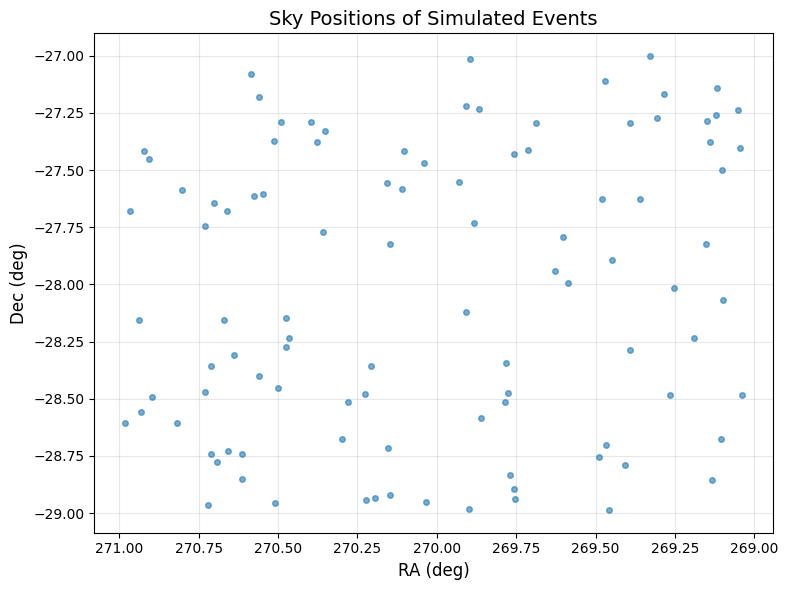

In [15]:
# Plot the sky positions of all simulated events
plt.figure(figsize=(8, 6))
plt.plot(lightcurves["ra"], lightcurves["dec"], ".", alpha=0.6, markersize=8)
plt.xlabel("RA (deg)", fontsize=12)
plt.ylabel("Dec (deg)", fontsize=12)
plt.gca().invert_xaxis()
plt.title("Sky Positions of Simulated Events", fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

<a id="7-plot-simulated-light-curves"></a>
## 7. Plot Simulated Light Curves

Let's visualize the first few simulated events. LightCurveLynx provides a built-in `plot_lightcurves` utility that color-codes by filter and displays error bars.

Each plot shows:
- **Colored points**: Observed flux with noise in each filter
- **Error bars**: Photometric uncertainties from the survey conditions
- **Vertical line**: True $t_0$ (time of closest approach)

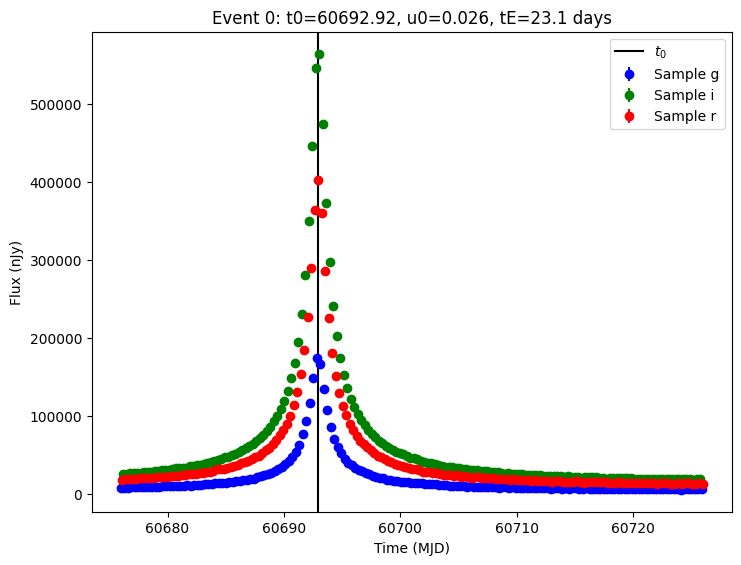

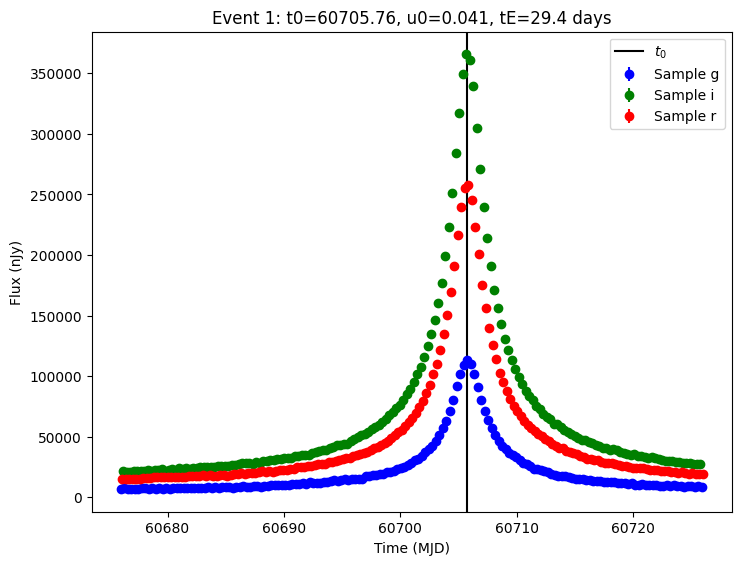

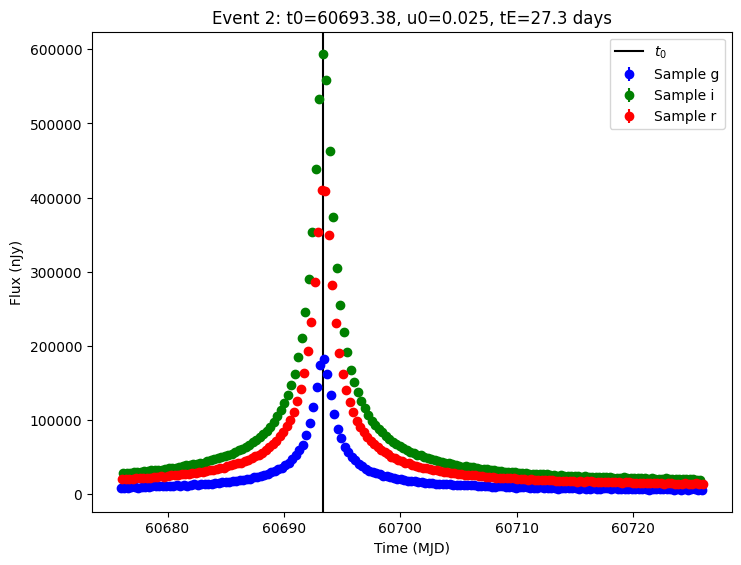

In [ ]:
# ============================================================
# TUNABLE: Number of events to plot
# ============================================================
n_plot = 3  # How many events to visualize

for idx in range(n_plot):
    # Extract the row for this object
    lc = lightcurves.loc[idx]

    if lc["nobs"] == 0:
        print(f"Event {idx}: No observations - skipping")
        continue

    # Unpack the nested columns
    lc_filters = np.asarray(lc["lightcurve"]["filter"], dtype=str)
    lc_mjd = np.asarray(lc["lightcurve"]["mjd"], dtype=float)
    lc_flux = np.asarray(lc["lightcurve"]["flux"], dtype=float)
    lc_fluxerr = np.asarray(lc["lightcurve"]["fluxerr"], dtype=float)

    # Extract key parameters for the title
    params = lc["params"]
    t0 = params["source.t0"]
    u0 = params["source.u0"]
    tE = params["source.tE"]

    # Plot using LightCurveLynx's built-in plotter
    ax = plot_lightcurves(
        fluxes=lc_flux,
        times=lc_mjd,
        fluxerrs=lc_fluxerr,
        filters=lc_filters,
        title=f"Event {idx}: t0={t0:.2f}, u0={u0:.3f}, tE={tE:.1f} days",
    )
    ax.axvline(t0, color="k", linestyle="-", linewidth=1.5, label="$t_0$")
    ax.legend()
    plt.show()

<a id="8-fspl-model-finite-source-effects"></a>
## 8. FSPL Model (Finite-Source Effects)

We can simulate different types of microlensing events by changing the model name and adding the required parameters. The **Finite-Source Point-Lens (FSPL)** model adds one extra parameter:

- **$\rho$** - the angular source radius in units of $\theta_E$ (the source size parameter)

Finite-source effects become important when $u_0 \lesssim \rho$, causing the magnification to deviate from the point-source approximation near the peak. This is critical for:
- Measuring the angular Einstein radius $\theta_E$ 
- Characterizing planetary caustic crossings
- Breaking the $u_0$–$\rho$ degeneracy

### Typical $\rho$ Values

| Source Type | Typical $\rho$ | Effect on Light Curve |
|------------|----------------|----------------------|
| Main sequence (G/K) | $10^{-4}$ – $10^{-3}$ | Subtle rounding of peak |
| Red giant | $10^{-3}$ – $10^{-2}$ | Significant peak flattening |
| Subgiant | $5 \times 10^{-4}$ – $5 \times 10^{-3}$ | Moderate finite-source effects |

> **Note:** The model name in LightCurveLynx is `"FSPLarge"` (matching PyLIMA's class name for the large finite-source model).

In [17]:
# ============================================================
# TUNABLE: FSPL model parameters
# ============================================================
# We reuse the same source/blend mags but add the rho parameter.
# rho is sampled uniformly on a log-like range.

fspl_pylima_params = {
    **pylima_params,  # Inherit u0, tE, piEN, piEE from above
    "rho": NumpyRandomFunc("uniform", low=1e-4, high=5e-3),  # Finite-source size
}

fspl_source = PyLIMAWrapperModel(
    "FSPLarge",                         # Finite-Source Point-Lens model
    source_mags=source_mags,
    blend_mags=blend_mags,
    ra=ra_sampler,
    dec=dec_sampler,
    t0=t0_sampler,
    parallax_model="Full",
    pylima_params=fspl_pylima_params,
    node_label="source",
)

print("FSPL model created!")
print(f"  Additional parameter: rho ~ Uniform[1e-4, 5e-3]")

# Generate a small batch of FSPL events
n_fspl = 3
fspl_lightcurves = simulate_lightcurves(
    fspl_source,
    n_fspl,
    obs_table,
    passband_group,
)

print(f"\nGenerated {len(fspl_lightcurves)} FSPL light curves.")

FSPL model created!
  Additional parameter: rho ~ Uniform[1e-4, 5e-3]


Simulating: 100%|██████████| 3/3 [00:00<00:00,  3.39obj/s]


Generated 3 FSPL light curves.


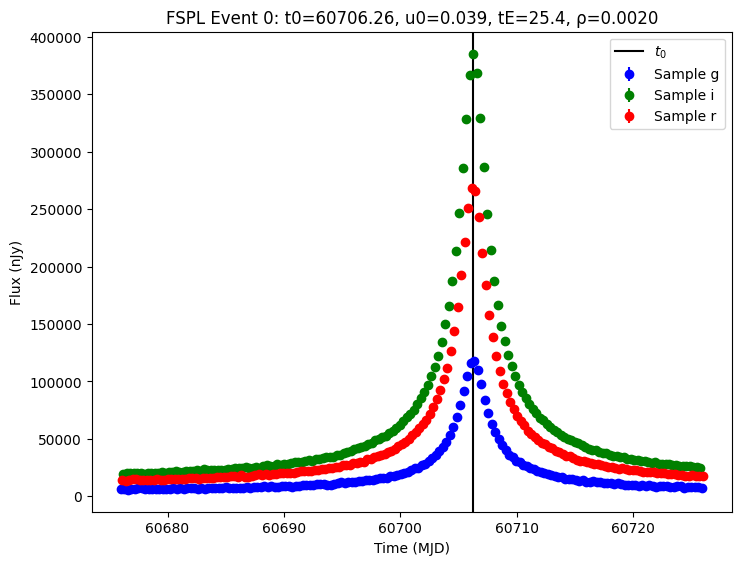

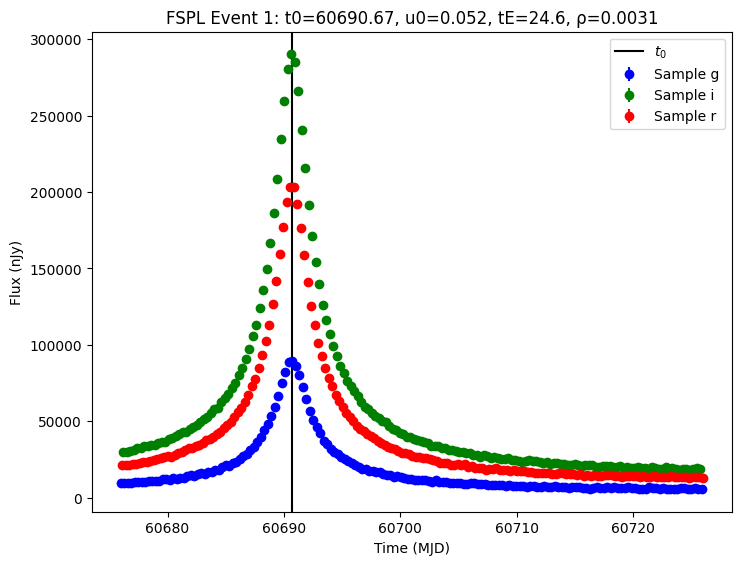

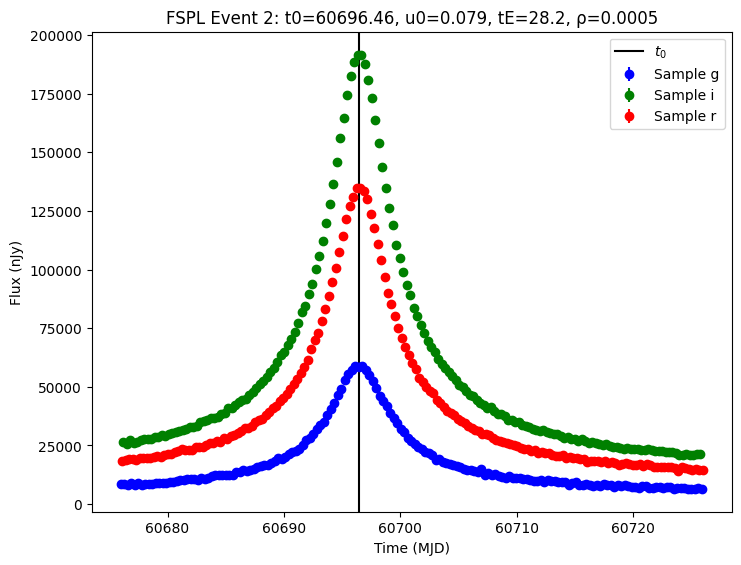

In [18]:
# Plot the FSPL light curves
for idx in range(n_fspl):
    lc = fspl_lightcurves.loc[idx]

    if lc["nobs"] == 0:
        continue

    lc_filters = np.asarray(lc["lightcurve"]["filter"], dtype=str)
    lc_mjd = np.asarray(lc["lightcurve"]["mjd"], dtype=float)
    lc_flux = np.asarray(lc["lightcurve"]["flux"], dtype=float)
    lc_fluxerr = np.asarray(lc["lightcurve"]["fluxerr"], dtype=float)

    params = lc["params"]
    t0 = params["source.t0"]
    u0 = params["source.u0"]
    tE = params["source.tE"]
    rho = params["source.rho"]

    ax = plot_lightcurves(
        fluxes=lc_flux,
        times=lc_mjd,
        fluxerrs=lc_fluxerr,
        filters=lc_filters,
        title=f"FSPL Event {idx}: t0={t0:.2f}, u0={u0:.3f}, tE={tE:.1f}, ρ={rho:.4f}",
    )
    ax.axvline(t0, color="k", linestyle="-", linewidth=1.5, label="$t_0$")
    ax.legend()
    plt.show()

<a id="8b-binary-lens-models"></a>
## 8b. Binary-Lens Models - PSBL, USBL & FSBL

Binary-lens microlensing occurs when the lens is a system of two masses (e.g., a star–planet or star–star binary). These events produce **caustic structures** in the magnification map that can create dramatic light curve features: sharp spikes, asymmetric peaks, and multi-peaked morphologies.

### Binary-Lens Model Hierarchy

PyLIMA provides three binary-lens models with increasing physical realism:

| Model | Full Name | Source Treatment | Limb Darkening | Speed | Use Case |
|-------|-----------|-----------------|----------------|-------|----------|
| **PSBL** | Point-Source Binary-Lens | Point source | N/A | Fastest | Quick surveys, initial parameter searches |
| **USBL** | Uniform-Source Binary-Lens | Finite uniform disk | No | Moderate | Standard simulations with finite-source effects |
| **FSBL** | Finite-Source Binary-Lens | Finite limb-darkened disk | Yes (linear $a_1$) | Slowest | High-fidelity simulations near caustic crossings |

### Binary-Lens Parameters

In addition to the standard PSPL parameters ($t_0$, $u_0$, $t_E$), binary-lens models require:

| Parameter | Symbol | Description | Typical Range |
|-----------|--------|-------------|---------------|
| `separation` | $s$ | Projected binary separation in $\theta_E$ units | 0.1 – 10.0 |
| `mass_ratio` | $q$ | Mass ratio $q = m_2 / m_1$ ($m_2 \leq m_1$) | $10^{-5}$ – 1.0 |
| `alpha` | $\alpha$ | Source trajectory angle relative to binary axis (radians) | $0$ – $2\pi$ |
| `rho` | $\rho$ | Normalized source radius (USBL/FSBL only) | $10^{-4}$ – $10^{-2}$ |

### Key Separation Regimes

The topology of the caustic structure depends on $s$ and $q$:

- **Close binary** ($s < 1$): Two small caustics, one near each lens
- **Intermediate/resonant** ($s \approx 1$): A single large central caustic - strongest magnification effects
- **Wide binary** ($s > 1$): One central caustic + one planetary caustic offset from the host

For **planetary events**, $q \ll 1$ (e.g., $q \sim 10^{-3}$ for a Jupiter-mass planet around a solar-mass star).

### 8b.1 PSBL - Point-Source Binary-Lens

The **PSBL** model treats the source as a point. This is the fastest binary-lens computation since it avoids the expensive finite-source integration. Use PSBL when:
- You need rapid generation of large simulation batches
- The source is far from caustics (no caustic crossing)
- You want an initial parameter search before adding finite-source effects

**Parameters:** `t0`, `u0`, `tE`, `separation`, `mass_ratio`, `alpha` (no `rho`)

In [ ]:
# ============================================================
# PSBL - Point-Source Binary-Lens
# ============================================================
# No rho parameter needed - point-source approximation.
# This is the fastest binary-lens model.

psbl_pylima_params = {
    "u0": NumpyRandomFunc("uniform", low=0.01, high=0.3),
    "tE": NumpyRandomFunc("uniform", low=20.0, high=60.0),
    "separation": NumpyRandomFunc("uniform", low=0.8, high=1.2),   # Near-resonant caustic
    "mass_ratio": NumpyRandomFunc("uniform", low=1e-3, high=0.1),  # Planetary to stellar companion
    "alpha": NumpyRandomFunc("uniform", low=0.0, high=2 * np.pi),  # Trajectory angle (radians)
    "piEN": 0.0,    # No parallax for this example
    "piEE": 0.0,
}

psbl_source = PyLIMAWrapperModel(
    "PSBL",
    source_mags=source_mags,
    blend_mags=blend_mags,
    ra=ra_sampler,
    dec=dec_sampler,
    t0=t0_sampler,
    parallax_model="None",
    pylima_params=psbl_pylima_params,
    node_label="source",
)

print("PSBL model created!")
print(f"  Parameters: t0, u0, tE, separation, mass_ratio, alpha")
print(f"  No finite-source effects (point source)")

# Generate PSBL events
n_psbl = 5
psbl_lightcurves = simulate_lightcurves(
    psbl_source,
    n_psbl,
    obs_table,
    passband_group,
)

print(f"\nGenerated {len(psbl_lightcurves)} PSBL light curves.")

PSBL model created!
  Parameters: t0, u0, tE, separation, mass_ratio, alpha
  No finite-source effects (point source)


Simulating: 100%|██████████| 5/5 [00:00<00:00,  6.53obj/s]


Generated 5 PSBL light curves.


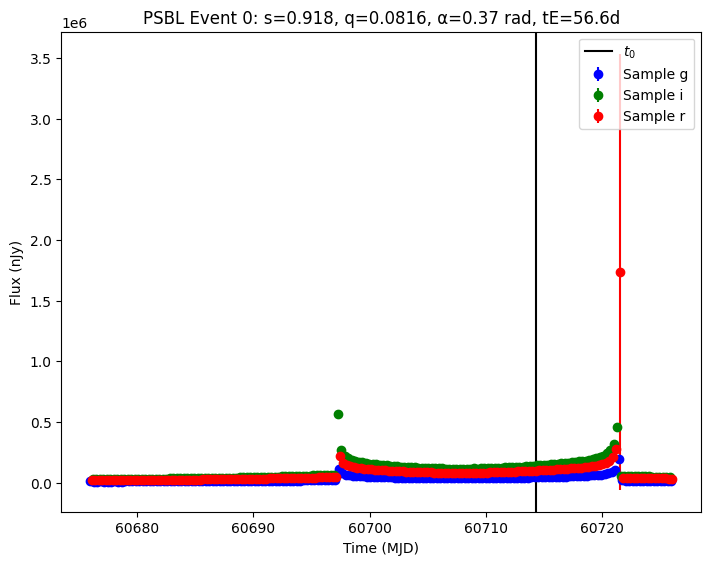

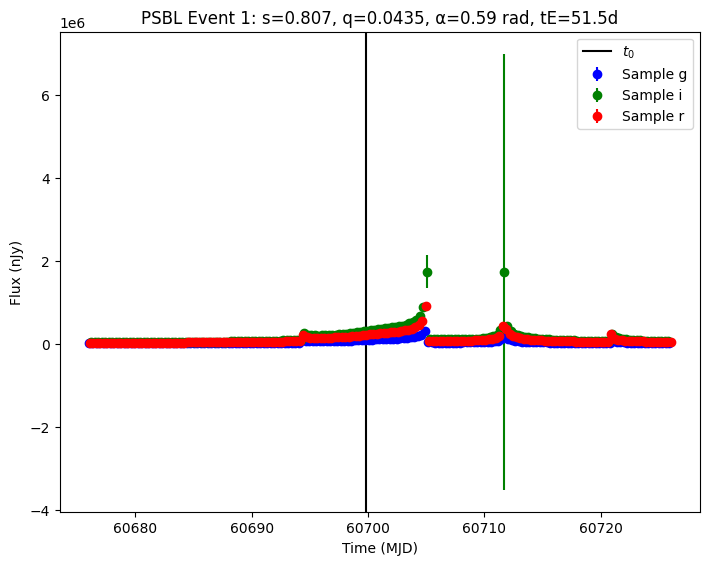

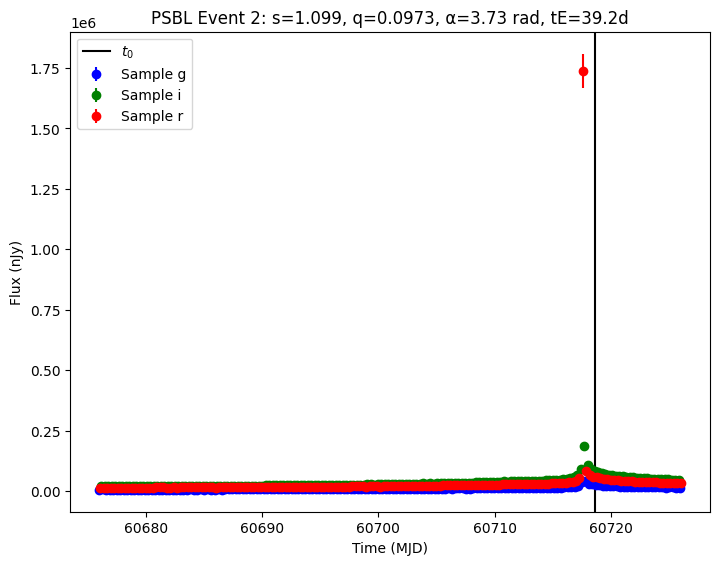

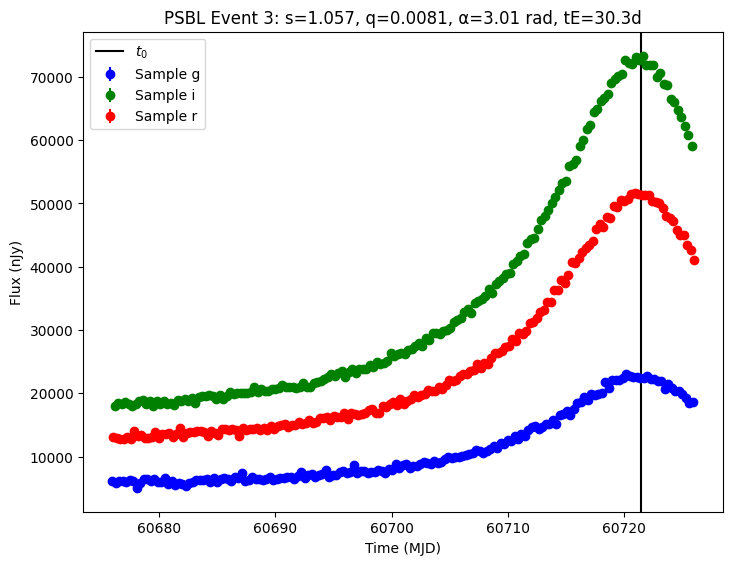

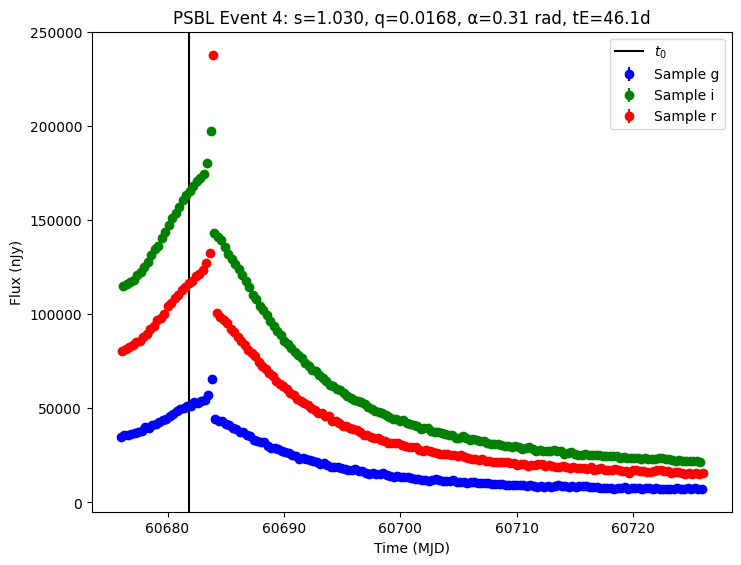

In [ ]:
# Plot the PSBL light curves
for idx in range(len(psbl_lightcurves)):
    lc = psbl_lightcurves.loc[idx]

    if lc["nobs"] == 0:
        print(f"PSBL Event {idx}: No observations - skipping")
        continue

    lc_filters = np.asarray(lc["lightcurve"]["filter"], dtype=str)
    lc_mjd = np.asarray(lc["lightcurve"]["mjd"], dtype=float)
    lc_flux = np.asarray(lc["lightcurve"]["flux"], dtype=float)
    lc_fluxerr = np.asarray(lc["lightcurve"]["fluxerr"], dtype=float)

    params = lc["params"]
    t0 = params["source.t0"]
    u0 = params["source.u0"]
    tE = params["source.tE"]
    s = params["source.separation"]
    q = params["source.mass_ratio"]
    alpha = params["source.alpha"]

    ax = plot_lightcurves(
        fluxes=lc_flux,
        times=lc_mjd,
        fluxerrs=lc_fluxerr,
        filters=lc_filters,
        title=f"PSBL Event {idx}: s={s:.3f}, q={q:.4f}, α={alpha:.2f} rad, tE={tE:.1f}d",
    )
    ax.axvline(t0, color="k", linestyle="-", linewidth=1.5, label="$t_0$")
    ax.legend()
    plt.show()

### 8b.2 USBL - Uniform-Source Binary-Lens

The **USBL** model adds finite-source effects by treating the source as a **uniform disk** with angular radius $\rho$ (in Einstein radius units). This is essential when the source crosses or approaches a caustic, because the point-source approximation diverges at caustic crossings while the finite-source model produces a smooth, finite peak.

**Parameters:** `t0`, `u0`, `tE`, `rho`, `separation`, `mass_ratio`, `alpha`

#### When to Use USBL vs. PSBL
- Use **USBL** when simulating caustic-crossing events or when $u_0 \lesssim \rho$
- Use **PSBL** for events far from caustics where finite-source effects are negligible
- USBL is more computationally expensive than PSBL due to the 2D source integration

In [ ]:
# ============================================================
# USBL - Uniform-Source Binary-Lens
# ============================================================
# Includes rho (finite source size) but NO limb darkening.
# The magnification is computed via VBB (Valerio Bozza's code).

usbl_pylima_params = {
    "u0": NumpyRandomFunc("uniform", low=0.01, high=0.2),
    "tE": NumpyRandomFunc("uniform", low=20.0, high=60.0),
    "rho": NumpyRandomFunc("uniform", low=1e-3, high=5e-3),    # Finite source size
    "separation": NumpyRandomFunc("uniform", low=0.6, high=1.5),
    "mass_ratio": NumpyRandomFunc("uniform", low=1e-4, high=0.05),
    "alpha": NumpyRandomFunc("uniform", low=0.0, high=2 * np.pi),
    "piEN": 0.0,
    "piEE": 0.0,
}

usbl_source = PyLIMAWrapperModel(
    "USBL",
    source_mags=source_mags,
    blend_mags=blend_mags,
    ra=ra_sampler,
    dec=dec_sampler,
    t0=t0_sampler,
    parallax_model="None",
    pylima_params=usbl_pylima_params,
    node_label="source",
)

print("USBL model created!")
print(f"  Parameters: t0, u0, tE, rho, separation, mass_ratio, alpha")
print(f"  Uniform source disk (no limb darkening)")

# Generate USBL events
n_usbl = 5
usbl_lightcurves = simulate_lightcurves(
    usbl_source,
    n_usbl,
    obs_table,
    passband_group,
)

print(f"\nGenerated {len(usbl_lightcurves)} USBL light curves.")

USBL model created!
  Parameters: t0, u0, tE, rho, separation, mass_ratio, alpha
  Uniform source disk (no limb darkening)


Simulating: 100%|██████████| 5/5 [00:01<00:00,  4.17obj/s]


Generated 5 USBL light curves.


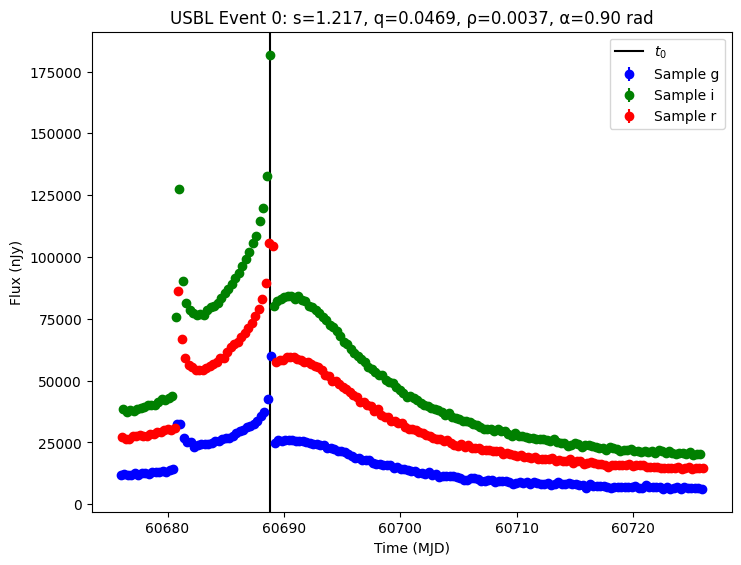

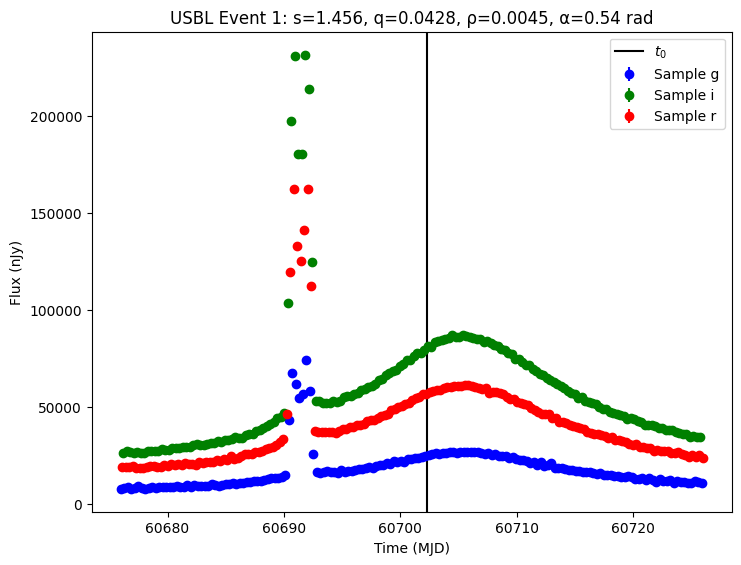

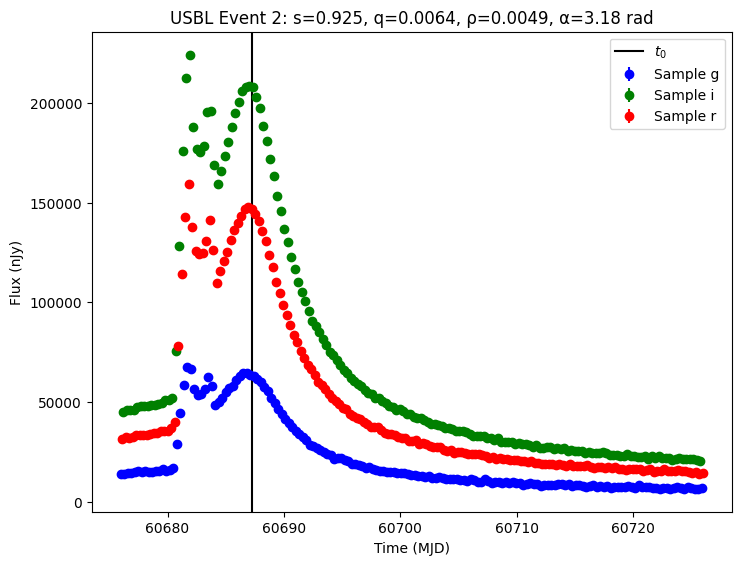

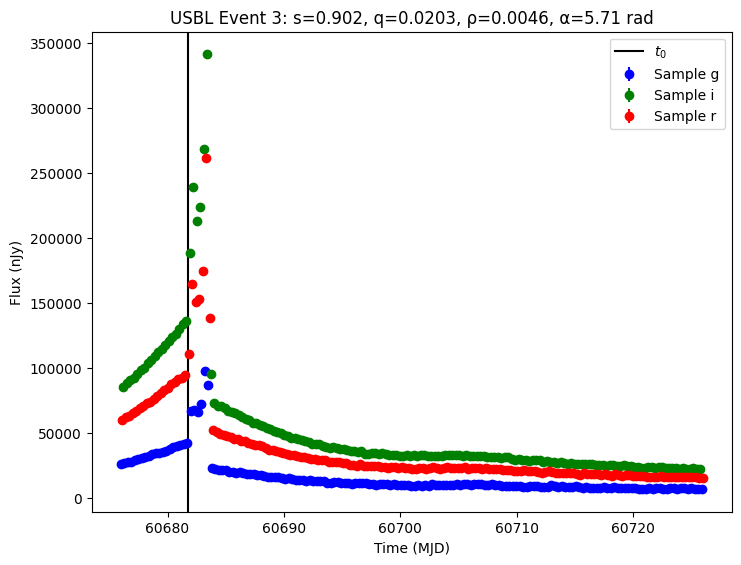

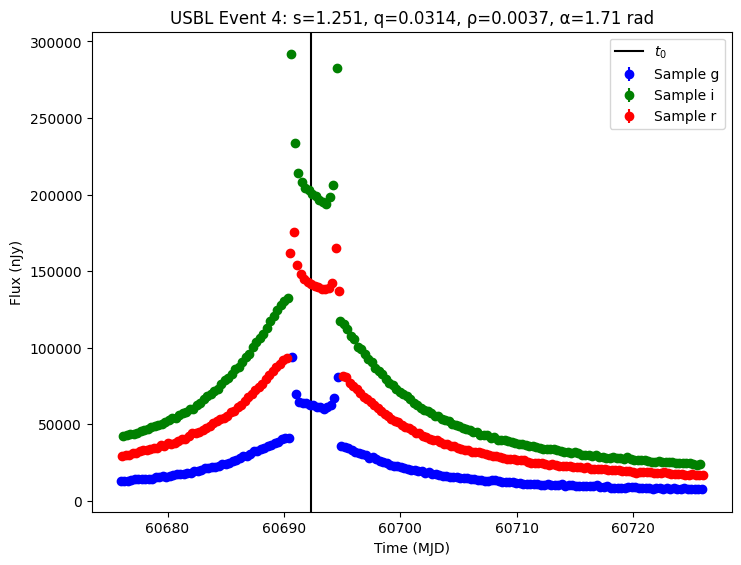

In [ ]:
# Plot the USBL light curves
for idx in range(len(usbl_lightcurves)):
    lc = usbl_lightcurves.loc[idx]

    if lc["nobs"] == 0:
        print(f"USBL Event {idx}: No observations - skipping")
        continue

    lc_filters = np.asarray(lc["lightcurve"]["filter"], dtype=str)
    lc_mjd = np.asarray(lc["lightcurve"]["mjd"], dtype=float)
    lc_flux = np.asarray(lc["lightcurve"]["flux"], dtype=float)
    lc_fluxerr = np.asarray(lc["lightcurve"]["fluxerr"], dtype=float)

    params = lc["params"]
    t0 = params["source.t0"]
    u0 = params["source.u0"]
    tE = params["source.tE"]
    rho = params["source.rho"]
    s = params["source.separation"]
    q = params["source.mass_ratio"]
    alpha = params["source.alpha"]

    ax = plot_lightcurves(
        fluxes=lc_flux,
        times=lc_mjd,
        fluxerrs=lc_fluxerr,
        filters=lc_filters,
        title=(f"USBL Event {idx}: s={s:.3f}, q={q:.4f}, "
               f"ρ={rho:.4f}, α={alpha:.2f} rad"),
    )
    ax.axvline(t0, color="k", linestyle="-", linewidth=1.5, label="$t_0$")
    ax.legend()
    plt.show()

<a id="8c-fsbl-limb-darkening"></a>
### 8b.3 FSBL - Finite-Source Binary-Lens with Limb Darkening

The **FSBL** model is the most physically realistic binary-lens model. It extends USBL by incorporating **limb darkening** - the center-to-limb variation of the source star's surface brightness. During caustic crossings, different parts of the source disk are magnified differently, making the light curve shape sensitive to limb darkening.

#### Limb Darkening Physics

The linear limb-darkening law describes the surface brightness profile as:

$$I(\mu) = I_0 \left[1 - a_1(1 - \mu)\right]$$

where $\mu = \cos\theta$ is the cosine of the angle between the line of sight and the surface normal, and $a_1$ is the **linear limb-darkening coefficient**.

PyLIMA supports two parameterizations:

| Convention | Parameters | Used By |
|-----------|------------|---------|
| **Classical** | $a_1$ (linear), $a_2$ (square-root) | `FSPLarge`, `FSBL` |
| **Microlensing** | $\Gamma$ (gamma), $\Sigma$ (sigma) | `FSPL` (Yoo approx.) |

The conversion between them:
$$\Gamma = \frac{10\, a_1}{15 - 5\, a_1 - 3\, a_2}, \qquad \Sigma = \frac{12\, a_2}{15 - 5\, a_1 - 3\, a_2}$$

#### Typical $a_1$ Values

| Source Type | Filter | $a_1$ |
|------------|--------|-------|
| G-dwarf (5500 K) | $r$ | ~0.55 |
| K-giant (4500 K) | $r$ | ~0.65 |
| K-giant (4500 K) | $i$ | ~0.50 |
| M-dwarf (3500 K) | $i$ | ~0.45 |

<br>

> **Note:** In LightCurveLynx, the FSBL model reads `telescope.ld_a1` from the PyLIMA telescope object. Since this is set internally (default = 0), we need to **monkey-patch** the `compute_bandflux` method to inject custom limb-darkening coefficients. The cell below demonstrates this approach.

In [ ]:
# ============================================================
# FSBL - Finite-Source Binary-Lens with Limb Darkening
# ============================================================
# FSBL uses the same parameters as USBL, but reads the
# limb-darkening coefficient (ld_a1) from the telescope object.
#
# Since LightCurveLynx creates telescopes internally with ld_a1=0,
# we subclass PyLIMAWrapperModel to inject custom limb-darkening
# coefficients per filter.

from lightcurvelynx.utils.io_utils import SquashOutput

class LimbDarkenedPyLIMAModel(PyLIMAWrapperModel):
    """PyLIMA wrapper that injects limb-darkening coefficients per filter.
    
    Parameters
    ----------
    ld_coeffs : dict
        Mapping from filter name to linear limb-darkening coefficient (a1).
        Example: {"g": 0.70, "r": 0.60, "i": 0.50}
    """
    
    def __init__(self, model_info, source_mags, *, ld_coeffs=None, **kwargs):
        self.ld_coeffs = ld_coeffs or {}
        super().__init__(model_info, source_mags, **kwargs)
    
    def compute_bandflux(self, times, filter, state):
        """Override to set limb-darkening on the telescope before evaluation."""
        if filter not in self.filters:
            raise ValueError(f"Filter '{filter}' is not supported by this model.")

        params = self.get_local_params(state)

        from pyLIMA.simulations import simulator

        t0_jd = params["t0"] + self.time_frame_offset
        times_jd = times + self.time_frame_offset

        with SquashOutput():
            current_event = self.make_pylima_event(
                params["ra"],
                params["dec"],
                filter=filter,
                times=times_jd,
            )

            # Inject limb-darkening coefficient on the telescope
            if filter in self.ld_coeffs:
                current_event.telescopes[0].ld_a1 = self.ld_coeffs[filter]
                current_event.telescopes[0].ld_a2 = 0.0  # Linear LD only

            model = self._model_class(
                current_event,
                parallax=[self.parallax_model, t0_jd],
                blend_flux_parameter=self.blend_flux_parameter,
            )

            expected_params_map = model.pyLIMA_standards_dictionnary
            ordered_values = [0.0] * len(expected_params_map)
            for name, index in expected_params_map.items():
                if name == "t0":
                    ordered_values[index] = t0_jd
                elif name in params:
                    ordered_values[index] = params[name]
            pyLIMA_params = model.compute_pyLIMA_parameters(ordered_values)

            simulator.simulate_lightcurve(model, pyLIMA_params, add_noise=False)
            fluxes = current_event.telescopes[0].lightcurve["flux"]

        return fluxes

print("LimbDarkenedPyLIMAModel class defined successfully!")

LimbDarkenedPyLIMAModel class defined successfully!


In [24]:
# ============================================================
# TUNABLE: Limb-darkening coefficients per filter
# ============================================================
# These are the linear limb-darkening coefficients (a1) for
# a typical K-giant source star. Adjust for your source type.
#
# a1 = 0: uniform disk (equivalent to USBL)
# a1 > 0: limb-darkened (center brighter than edge)

ld_coeffs = {
    "g": 0.70,   # Stronger LD at shorter wavelengths
    "r": 0.60,
    "i": 0.50,   # Weaker LD at longer wavelengths
}

fsbl_pylima_params = {
    "u0": NumpyRandomFunc("uniform", low=0.005, high=0.1),
    "tE": NumpyRandomFunc("uniform", low=20.0, high=60.0),
    "rho": NumpyRandomFunc("uniform", low=1e-3, high=8e-3),    # Larger source for visible LD effects
    "separation": NumpyRandomFunc("uniform", low=0.7, high=1.3),
    "mass_ratio": NumpyRandomFunc("uniform", low=1e-3, high=0.05),
    "alpha": NumpyRandomFunc("uniform", low=0.0, high=2 * np.pi),
    "piEN": 0.0,
    "piEE": 0.0,
}

fsbl_source = LimbDarkenedPyLIMAModel(
    "FSBL",
    source_mags=source_mags,
    blend_mags=blend_mags,
    ld_coeffs=ld_coeffs,
    ra=ra_sampler,
    dec=dec_sampler,
    t0=t0_sampler,
    parallax_model="None",
    pylima_params=fsbl_pylima_params,
    node_label="source",
)

print("FSBL model created with limb darkening!")
print(f"  Limb-darkening coefficients (a1):")
for band, a1 in ld_coeffs.items():
    print(f"    {band}: {a1}")

# Generate FSBL events
n_fsbl = 5
fsbl_lightcurves = simulate_lightcurves(
    fsbl_source,
    n_fsbl,
    obs_table,
    passband_group,
)

print(f"\nGenerated {len(fsbl_lightcurves)} FSBL light curves.")

FSBL model created with limb darkening!
  Limb-darkening coefficients (a1):
    g: 0.7
    r: 0.6
    i: 0.5


Simulating: 100%|██████████| 5/5 [00:00<00:00,  5.05obj/s]


Generated 5 FSBL light curves.


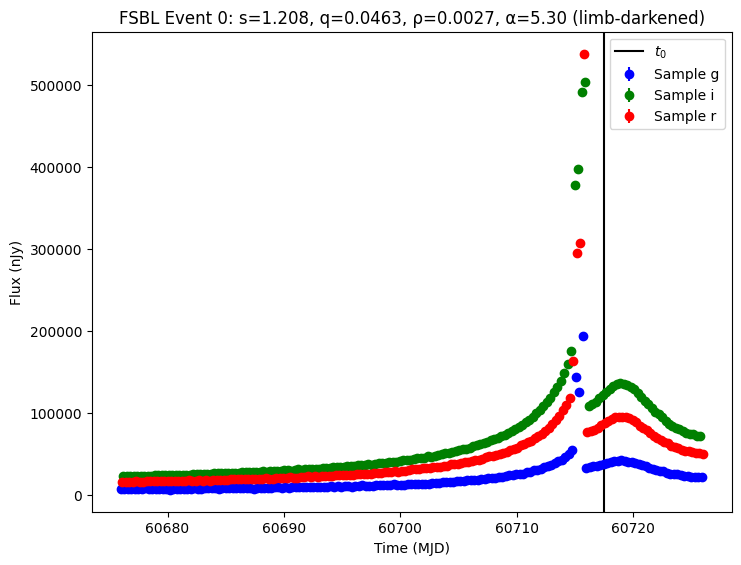

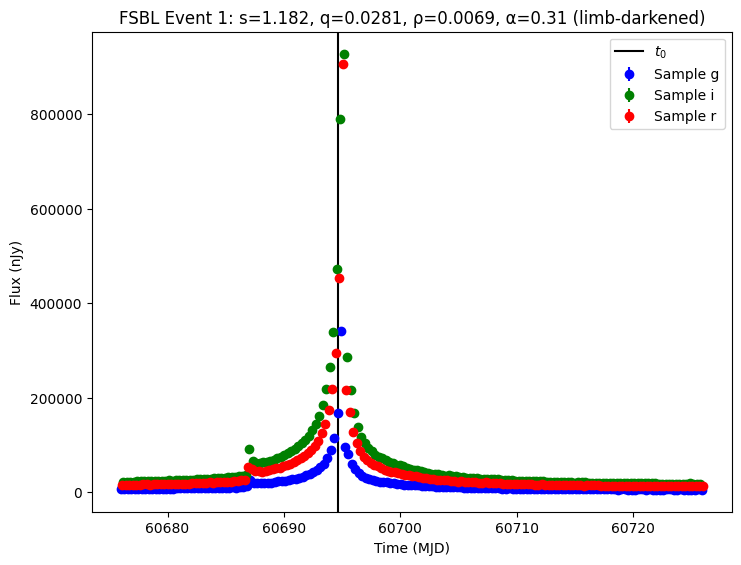

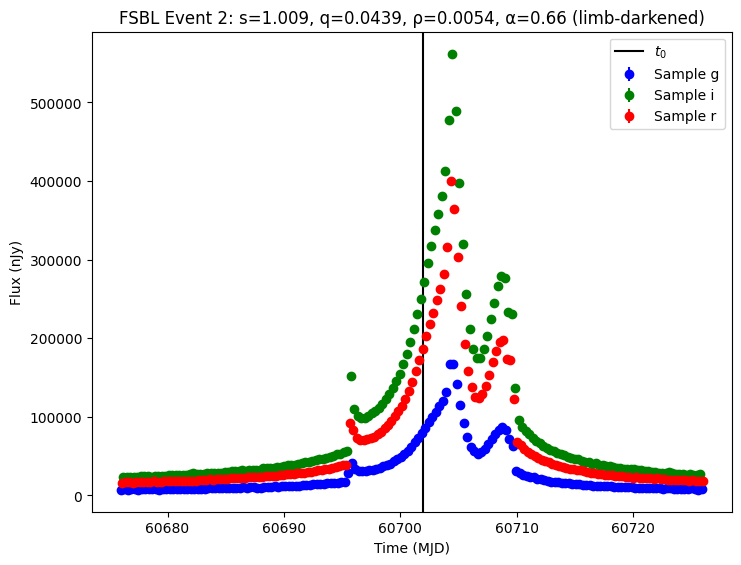

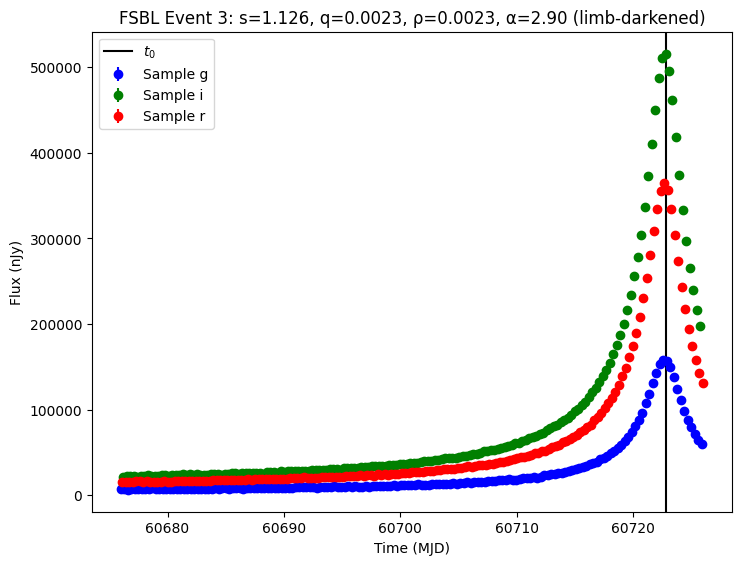

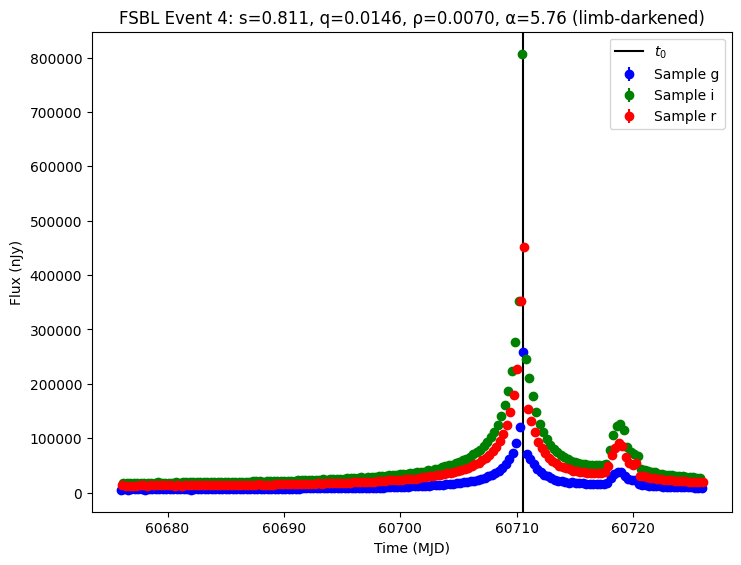

In [ ]:
# Plot the FSBL light curves
for idx in range(len(fsbl_lightcurves)):
    lc = fsbl_lightcurves.loc[idx]

    if lc["nobs"] == 0:
        print(f"FSBL Event {idx}: No observations - skipping")
        continue

    lc_filters = np.asarray(lc["lightcurve"]["filter"], dtype=str)
    lc_mjd = np.asarray(lc["lightcurve"]["mjd"], dtype=float)
    lc_flux = np.asarray(lc["lightcurve"]["flux"], dtype=float)
    lc_fluxerr = np.asarray(lc["lightcurve"]["fluxerr"], dtype=float)

    params = lc["params"]
    t0 = params["source.t0"]
    u0 = params["source.u0"]
    tE = params["source.tE"]
    rho = params["source.rho"]
    s = params["source.separation"]
    q = params["source.mass_ratio"]
    alpha = params["source.alpha"]

    ax = plot_lightcurves(
        fluxes=lc_flux,
        times=lc_mjd,
        fluxerrs=lc_fluxerr,
        filters=lc_filters,
        title=(f"FSBL Event {idx}: s={s:.3f}, q={q:.4f}, "
               f"ρ={rho:.4f}, α={alpha:.2f} (limb-darkened)"),
    )
    ax.axvline(t0, color="k", linestyle="-", linewidth=1.5, label="$t_0$")
    ax.legend()
    plt.show()

<a id="8d-binary-parallax"></a>
### 8b.4 Binary-Lens Events with Parallax

For long-duration binary-lens events ($t_E \gtrsim 30$ days), **microlensing parallax** becomes detectable. The parallax vector $\boldsymbol{\pi}_E = (\pi_{E,N}, \pi_{E,E})$ encodes the lens-source relative parallax and is crucial for measuring the lens mass.

PyLIMA supports several parallax modes:

| Mode | Description | When to Use |
|------|-------------|-------------|
| `"None"` | No parallax | Short events ($t_E \lesssim 20$ days) |
| `"Annual"` | Earth's orbital motion only | Standard ground-based observations |
| `"Terrestrial"` | Earth's rotation only | Simultaneous multi-site observations |
| `"Full"` | Annual + Terrestrial | Most complete model |

When parallax is enabled, two additional parameters are required:
- **$\pi_{E,N}$** (`piEN`) - North component of the parallax vector
- **$\pi_{E,E}$** (`piEE`) - East component of the parallax vector

The magnitude of the parallax vector relates to physical properties:
$$\pi_E = |\boldsymbol{\pi}_E| = \sqrt{\pi_{E,N}^2 + \pi_{E,E}^2} = \frac{\pi_\text{rel}}{\theta_E}$$

where $\pi_\text{rel}$ is the lens-source relative parallax and $\theta_E$ is the angular Einstein radius.

Below we demonstrate all three parallax modes applied to a USBL model, showing how the light curve morphology changes with parallax.

In [ ]:
# ============================================================
# USBL with Full Parallax - Long-Duration Binary Events
# ============================================================
# We use a longer observation window and longer tE to make
# parallax effects visible in the light curve morphology.
#
# TUNABLE: Parallax mode options: "None", "Annual", "Full"

# Extended observation window for parallax sensitivity
num_days_long = 365
mjd_start_long = 60676.0
mjd_end_long = mjd_start_long + num_days_long
num_samples_long = 1500

# Build extended OpSim
survey_data_long = {
    "observationStartMJD": np.linspace(mjd_start_long, mjd_end_long, num_samples_long),
    "fieldRA": np.full(num_samples_long, field_ra),
    "fieldDec": np.full(num_samples_long, field_dec),
    "zp_nJy": np.random.normal(loc=1.0, scale=0.1, size=num_samples_long),
    "filter": [filters[i % len(filters)] for i in range(num_samples_long)],
    "seeing": np.random.normal(loc=1.1, scale=0.1, size=num_samples_long),
    "skybrightness": np.random.normal(loc=20.0, scale=0.1, size=num_samples_long),
    "exptime": np.full(num_samples_long, 30.0),
    "nexposure": np.full(num_samples_long, 2),
}
obs_table_long = OpSim(survey_data_long)

t0_sampler_long = NumpyRandomFunc("uniform", low=mjd_start_long + 60, high=mjd_end_long - 60)

print(f"Extended OpSim: {num_samples_long} visits over {num_days_long} days")

Extended OpSim: 1500 visits over 365 days


In [27]:
# ============================================================
# Compare: USBL with No Parallax vs. Annual vs. Full Parallax
# ============================================================

parallax_modes = {
    "None": {
        "parallax_model": "None",
        "extra_params": {},
    },
    "Annual": {
        "parallax_model": "Annual",
        "extra_params": {
            "piEN": NumpyRandomFunc("uniform", low=-0.3, high=0.3),
            "piEE": NumpyRandomFunc("uniform", low=-0.3, high=0.3),
        },
    },
    "Full": {
        "parallax_model": "Full",
        "extra_params": {
            "piEN": NumpyRandomFunc("uniform", low=-0.3, high=0.3),
            "piEE": NumpyRandomFunc("uniform", low=-0.3, high=0.3),
        },
    },
}

# Base binary-lens parameters (shared across all parallax modes)
base_binary_params = {
    "u0": NumpyRandomFunc("uniform", low=0.01, high=0.2),
    "tE": NumpyRandomFunc("uniform", low=60.0, high=150.0),   # Long tE for parallax
    "rho": NumpyRandomFunc("uniform", low=1e-3, high=5e-3),
    "separation": NumpyRandomFunc("uniform", low=0.8, high=1.2),
    "mass_ratio": NumpyRandomFunc("uniform", low=1e-3, high=0.05),
    "alpha": NumpyRandomFunc("uniform", low=0.0, high=2 * np.pi),
}

parallax_results = {}

for mode_name, mode_config in parallax_modes.items():
    print(f"\n--- Generating USBL events with parallax_model='{mode_name}' ---")

    mode_params = {**base_binary_params, **mode_config["extra_params"]}

    # For "None" parallax, piEN/piEE are still required by the model parameter map
    # but they have no effect. We set them to zero.
    if mode_name == "None":
        mode_params["piEN"] = 0.0
        mode_params["piEE"] = 0.0

    model = PyLIMAWrapperModel(
        "USBL",
        source_mags=source_mags,
        blend_mags=blend_mags,
        ra=ra_sampler,
        dec=dec_sampler,
        t0=t0_sampler_long,
        parallax_model=mode_config["parallax_model"],
        pylima_params=mode_params,
        node_label="source",
    )

    lcs = simulate_lightcurves(
        model,
        3,
        obs_table_long,
        passband_group,
    )

    parallax_results[mode_name] = lcs
    print(f"  Generated {len(lcs)} events with '{mode_name}' parallax")

print("\nAll parallax modes simulated!")


--- Generating USBL events with parallax_model='None' ---


Simulating: 100%|██████████| 3/3 [00:00<00:00,  5.94obj/s]


  Generated 3 events with 'None' parallax

--- Generating USBL events with parallax_model='Annual' ---


Simulating: 100%|██████████| 3/3 [00:01<00:00,  2.05obj/s]


  Generated 3 events with 'Annual' parallax

--- Generating USBL events with parallax_model='Full' ---


Simulating: 100%|██████████| 3/3 [00:01<00:00,  1.85obj/s]

  Generated 3 events with 'Full' parallax

All parallax modes simulated!


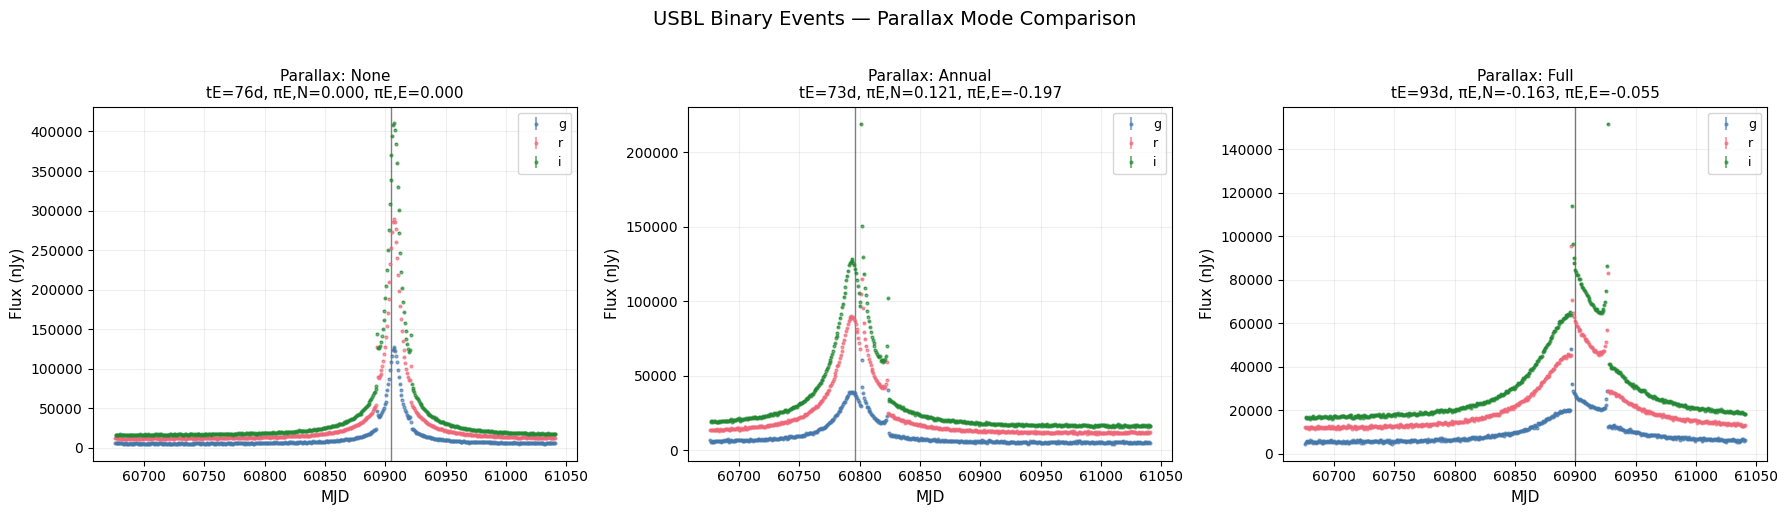

In [ ]:
# ============================================================
# Plot parallax comparison: one event per parallax mode
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

for ax_idx, (mode_name, lcs) in enumerate(parallax_results.items()):
    ax = axes[ax_idx]
    lc = lcs.loc[0]

    if lc["nobs"] == 0:
        ax.set_title(f"{mode_name} Parallax\n(no observations)")
        continue

    lc_filters = np.asarray(lc["lightcurve"]["filter"], dtype=str)
    lc_mjd = np.asarray(lc["lightcurve"]["mjd"], dtype=float)
    lc_flux = np.asarray(lc["lightcurve"]["flux"], dtype=float)
    lc_fluxerr = np.asarray(lc["lightcurve"]["fluxerr"], dtype=float)

    params = lc["params"]
    t0 = params["source.t0"]
    tE = params["source.tE"]

    # Color-code by filter
    filter_colors = {"g": "#4477AA", "r": "#EE6677", "i": "#228833"}
    for filt in filters:
        mask = lc_filters == filt
        if np.any(mask):
            ax.errorbar(
                lc_mjd[mask], lc_flux[mask], yerr=lc_fluxerr[mask],
                fmt=".", color=filter_colors.get(filt, "gray"),
                alpha=0.6, markersize=4, label=filt,
            )

    ax.axvline(t0, color="k", linestyle="-", linewidth=1, alpha=0.5)
    ax.set_xlabel("MJD", fontsize=11)
    ax.set_ylabel("Flux (nJy)", fontsize=11)

    piEN = params.get("source.piEN", 0)
    piEE = params.get("source.piEE", 0)
    ax.set_title(
        f"Parallax: {mode_name}\n"
        f"tE={tE:.0f}d, πE,N={piEN:.3f}, πE,E={piEE:.3f}",
        fontsize=11,
    )
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.2)

plt.suptitle("USBL Binary Events - Parallax Mode Comparison", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### 8b.5 Binary-Lens Prior Tuning Recipes

Below are recommended configurations for common binary-lens science cases.

---

#### Recipe A: Planetary Caustic Crossing (Wide Binary)
Best for detecting planetary signals with well-resolved caustic features.

```python
pylima_params = {
    "u0": NumpyRandomFunc("uniform", low=0.001, high=0.05),
    "tE": NumpyRandomFunc("uniform", low=20.0, high=80.0),
    "rho": NumpyRandomFunc("uniform", low=5e-4, high=5e-3),
    "separation": NumpyRandomFunc("uniform", low=1.1, high=2.0),     # Wide binary
    "mass_ratio": NumpyRandomFunc("uniform", low=1e-4, high=1e-2),   # Planetary regime
    "alpha": NumpyRandomFunc("uniform", low=0.0, high=2*np.pi),
    "piEN": 0.0, "piEE": 0.0,
}
```

---

#### Recipe B: Resonant Caustic (Close/Intermediate Binary)
Best for detecting strong binary signals with large, merged caustics.

```python
pylima_params = {
    "u0": NumpyRandomFunc("uniform", low=0.01, high=0.3),
    "tE": NumpyRandomFunc("uniform", low=15.0, high=60.0),
    "rho": NumpyRandomFunc("uniform", low=1e-3, high=1e-2),
    "separation": NumpyRandomFunc("uniform", low=0.6, high=1.0),     # Close/resonant
    "mass_ratio": NumpyRandomFunc("uniform", low=0.01, high=1.0),    # Stellar companion
    "alpha": NumpyRandomFunc("uniform", low=0.0, high=2*np.pi),
    "piEN": 0.0, "piEE": 0.0,
}
```

---

#### Recipe C: Long-Duration Binary with Parallax + Limb Darkening (FSBL)
The most physically complete simulation for high-fidelity caustic-crossing events.

```python
ld_coeffs = {"g": 0.70, "r": 0.60, "i": 0.50}

pylima_params = {
    "u0": NumpyRandomFunc("uniform", low=0.005, high=0.1),
    "tE": NumpyRandomFunc("uniform", low=80.0, high=300.0),
    "rho": NumpyRandomFunc("uniform", low=1e-3, high=8e-3),
    "separation": NumpyRandomFunc("uniform", low=0.7, high=1.5),
    "mass_ratio": NumpyRandomFunc("uniform", low=1e-3, high=0.1),
    "alpha": NumpyRandomFunc("uniform", low=0.0, high=2*np.pi),
    "piEN": NumpyRandomFunc("uniform", low=-0.5, high=0.5),
    "piEE": NumpyRandomFunc("uniform", low=-0.5, high=0.5),
}

model = LimbDarkenedPyLIMAModel(
    "FSBL",
    source_mags=source_mags,
    blend_mags=blend_mags,
    ld_coeffs=ld_coeffs,
    ra=ra_sampler, dec=dec_sampler, t0=t0_sampler,
    parallax_model="Full",
    pylima_params=pylima_params,
    node_label="source",
)
```

---

### Model Selection Guide

| Science Case | Best Model | Parallax | Key Considerations |
|---|---|---|---|
| Quick population surveys | PSBL | None | Fastest, good for bulk statistics |
| Standard planetary events | USBL | None or Annual | Finite-source resolves caustic crossings |
| High-fidelity caustic crossings | FSBL | Full | Limb darkening affects crossing morphology |
| Long-duration events ($t_E > 60$d) | USBL/FSBL | Annual or Full | Parallax essential for mass measurement |
| Free-floating planet searches | FSPL | None | Single-lens, very short $t_E$ |

<a id="9-customizing-priors--a-parameter-tuning-guide"></a>
## 9. Customizing Priors - A Parameter Tuning Guide

This section is a reference for customizing every aspect of the simulation. The `NumpyRandomFunc` class wraps any `numpy.random` distribution, giving you full control over parameter priors.

### `NumpyRandomFunc` Syntax

```python
# Uniform distribution
NumpyRandomFunc("uniform", low=0.01, high=1.0)

# Normal (Gaussian) distribution
NumpyRandomFunc("normal", loc=0.5, scale=0.1)

# Log-uniform (uniform in log space)
NumpyRandomFunc("uniform", low=np.log10(1e-4), high=np.log10(1e-1))
# Then exponentiate: 10**sampled_value

# Fixed value (just pass a float)
0.1  # No distribution needed
```

### Parameter Tuning Recipes

Below are recommended prior configurations for common science cases.

---

#### Recipe 1: High-Magnification PSPL Events
Best for studying events with strong photometric signals and well-constrained parameters.

```python
pylima_params = {
    "u0": NumpyRandomFunc("uniform", low=0.001, high=0.05),  # Very close approach
    "tE": NumpyRandomFunc("uniform", low=10.0, high=100.0),  # Moderate timescales
    "piEN": NumpyRandomFunc("normal", loc=0.0, scale=0.1),   # Small parallax
    "piEE": NumpyRandomFunc("normal", loc=0.0, scale=0.1),
}
```

---

#### Recipe 2: Long-Duration Events with Parallax
Best for events where annual parallax effects are prominent.

```python
pylima_params = {
    "u0": NumpyRandomFunc("uniform", low=0.01, high=0.5),
    "tE": NumpyRandomFunc("uniform", low=100.0, high=500.0), # Long timescales
    "piEN": NumpyRandomFunc("uniform", low=-0.5, high=0.5),  # Significant parallax
    "piEE": NumpyRandomFunc("uniform", low=-0.5, high=0.5),
}
```

---

#### Recipe 3: Faint Source in Crowded Field
Simulates events with significant blending contamination.

```python
source_mags = {
    "g": NumpyRandomFunc("uniform", low=23.0, high=25.0),  # Faint source
    "r": NumpyRandomFunc("uniform", low=22.5, high=24.5),
    "i": NumpyRandomFunc("uniform", low=22.0, high=24.0),
}
blend_mags = {
    "g": 21.0,  # Bright blend (dominates baseline)
    "r": 20.5,
    "i": 20.0,
}
```

---

#### Recipe 4: FSPL with Large Finite-Source Effects
For red giant sources where finite-source effects are prominent.

```python
fspl_params = {
    "u0": NumpyRandomFunc("uniform", low=0.001, high=0.01),  # Very high mag
    "tE": NumpyRandomFunc("uniform", low=20.0, high=60.0),
    "piEN": 0.0,
    "piEE": 0.0,
    "rho": NumpyRandomFunc("uniform", low=1e-3, high=1e-2),  # Large source
}
```

---

### Disabling Parallax

To simulate events without parallax effects, set `parallax_model="None"` when creating the model and remove `piEN`/`piEE` from `pylima_params`:

```python
no_parallax_source = PyLIMAWrapperModel(
    "PSPL",
    source_mags=source_mags,
    blend_mags=blend_mags,
    ra=ra_sampler,
    dec=dec_sampler,
    t0=t0_sampler,
    parallax_model="None",   # <-- Disable parallax
    pylima_params={
        "u0": NumpyRandomFunc("uniform", low=0.01, high=0.5),
        "tE": NumpyRandomFunc("uniform", low=10.0, high=100.0),
    },
    node_label="source",
)
```

### Removing Blending

To simulate events with no blend flux (isolated source), simply omit `blend_mags`:

```python
no_blend_source = PyLIMAWrapperModel(
    "PSPL",
    source_mags=source_mags,
    # blend_mags omitted - LightCurveLynx defaults to zero blend flux
    ra=ra_sampler,
    dec=dec_sampler,
    t0=t0_sampler,
    parallax_model="Full",
    pylima_params=pylima_params,
    node_label="source",
)
```

Simulating: 100%|██████████| 3/3 [00:00<00:00,  3.53obj/s]


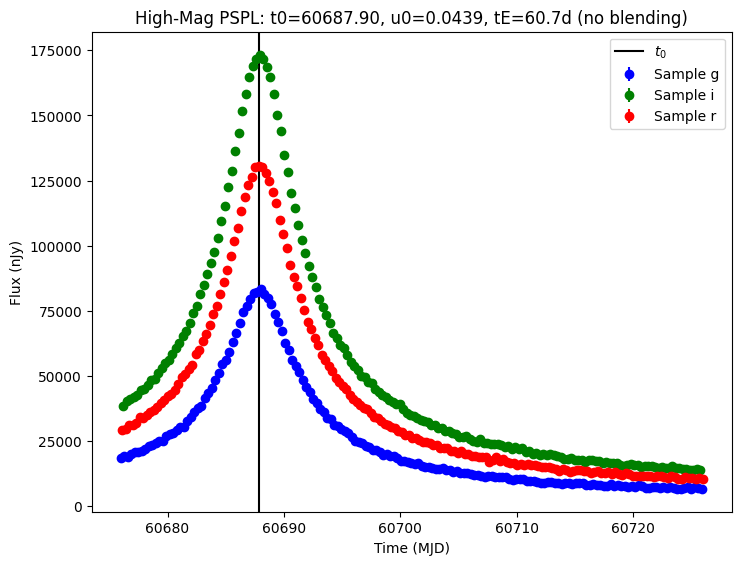

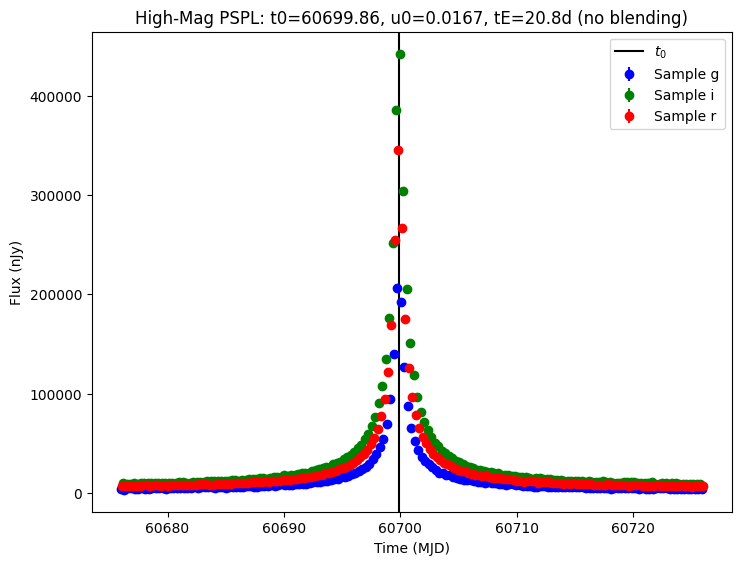

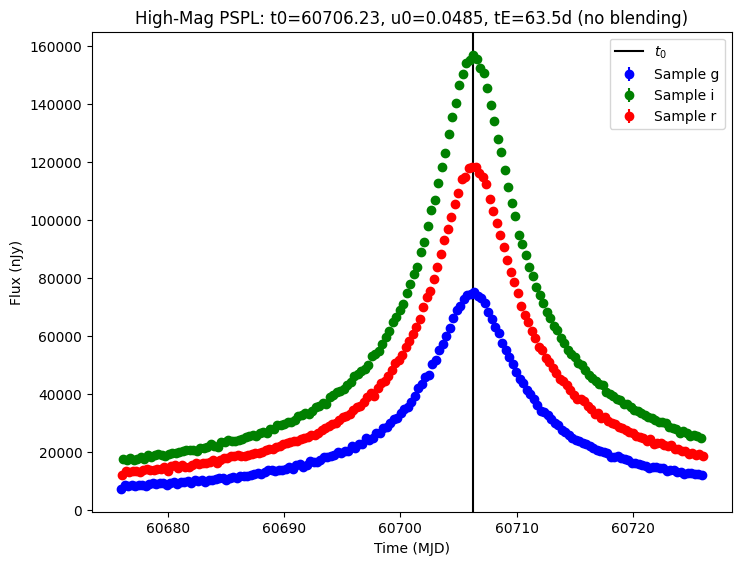

In [ ]:
# ============================================================
# Example: Create a high-magnification PSPL model with
#          Gaussian parallax priors and no blending
# ============================================================

highmag_params = {
    "u0": NumpyRandomFunc("uniform", low=0.001, high=0.05),
    "tE": NumpyRandomFunc("uniform", low=15.0, high=80.0),
    "piEN": NumpyRandomFunc("normal", loc=0.0, scale=0.1),
    "piEE": NumpyRandomFunc("normal", loc=0.0, scale=0.1),
}

highmag_source_mags = {
    "g": 22.5,
    "r": 22.0,
    "i": 21.7,
}

highmag_model = PyLIMAWrapperModel(
    "PSPL",
    source_mags=highmag_source_mags,
    # No blend_mags - zero blend flux
    ra=ra_sampler,
    dec=dec_sampler,
    t0=t0_sampler,
    parallax_model="Full",
    pylima_params=highmag_params,
    node_label="source",
)

# Generate a few events
highmag_lcs = simulate_lightcurves(
    highmag_model,
    3,
    obs_table,
    passband_group,
)

# Plot
for idx in range(len(highmag_lcs)):
    lc = highmag_lcs.loc[idx]
    if lc["nobs"] == 0:
        continue

    lc_filters = np.asarray(lc["lightcurve"]["filter"], dtype=str)
    lc_mjd = np.asarray(lc["lightcurve"]["mjd"], dtype=float)
    lc_flux = np.asarray(lc["lightcurve"]["flux"], dtype=float)
    lc_fluxerr = np.asarray(lc["lightcurve"]["fluxerr"], dtype=float)

    params = lc["params"]
    t0 = params["source.t0"]
    u0 = params["source.u0"]
    tE = params["source.tE"]

    ax = plot_lightcurves(
        fluxes=lc_flux,
        times=lc_mjd,
        fluxerrs=lc_fluxerr,
        filters=lc_filters,
        title=f"High-Mag PSPL: t0={t0:.2f}, u0={u0:.4f}, tE={tE:.1f}d (no blending)",
    )
    ax.axvline(t0, color="k", linestyle="-", linewidth=1.5, label="$t_0$")
    ax.legend()
    plt.show()

<a id="10-saving-and-exporting-results"></a>
## 10. Saving and Exporting Results

The simulated light curves can be exported for downstream analysis, NBI training, or sharing with collaborators.

### Option 1: Save the full nested-pandas DataFrame
Use `to_parquet()` to save the complete output including all metadata and nested light curves.

### Option 2: Extract individual light curves to CSV/text
Loop over events and save each light curve as a text file (compatible with fitting codes).

### Option 3: Use MicroLIA-Simulate's helper functions
If you also have the `MicroLIA-Simulate` package, you can use `write_lightcurves_txt()` and `plot_lightcurves_mag()` for quick I/O.

In [29]:
# ============================================================
# Export individual light curves to text files
# ============================================================
import os

output_dir = "simulated_lightcurves"
os.makedirs(output_dir, exist_ok=True)

# Save the first 3 events as example text files
n_export = min(3, len(lightcurves))

for idx in range(n_export):
    lc = lightcurves.loc[idx]
    if lc["nobs"] == 0:
        continue

    lc_data = lc["lightcurve"]
    params = lc["params"]

    output_file = os.path.join(output_dir, f"event_{idx:04d}.txt")
    with open(output_file, "w") as f:
        # Write header with parameter metadata
        f.write(f"# Simulated PSPL Microlensing Event {idx}\n")
        f.write(f"# t0 = {params['source.t0']:.6f}\n")
        f.write(f"# u0 = {params['source.u0']:.6f}\n")
        f.write(f"# tE = {params['source.tE']:.4f}\n")
        f.write(f"# ra = {lc['ra']:.6f}\n")
        f.write(f"# dec = {lc['dec']:.6f}\n")
        f.write(f"# Columns: mjd\tfilter\tflux\tfluxerr\tflux_perfect\n")

        # Write data
        for _, row in lc_data.iterrows():
            f.write(f"{row['mjd']:.6f}\t{row['filter']}\t{row['flux']:.6f}\t"
                    f"{row['fluxerr']:.6f}\t{row['flux_perfect']:.6f}\n")

    print(f"Saved: {output_file}")

print(f"\nExported {n_export} light curves to '{output_dir}/' directory")

Saved: simulated_lightcurves\event_0000.txt
Saved: simulated_lightcurves\event_0001.txt
Saved: simulated_lightcurves\event_0002.txt

Exported 3 light curves to 'simulated_lightcurves/' directory


In [30]:
# ============================================================
# Build a summary table of all simulated event parameters
# ============================================================
import pandas as pd

summary_rows = []
for idx in range(len(lightcurves)):
    lc = lightcurves.loc[idx]
    params = lc["params"]

    summary_rows.append({
        "event_id": idx,
        "ra": lc["ra"],
        "dec": lc["dec"],
        "nobs": lc["nobs"],
        "t0": params.get("source.t0", np.nan),
        "u0": params.get("source.u0", np.nan),
        "tE": params.get("source.tE", np.nan),
        "piEN": params.get("source.piEN", np.nan),
        "piEE": params.get("source.piEE", np.nan),
    })

summary_df = pd.DataFrame(summary_rows)
print("Parameter Summary Table (first 10 events):")
print(summary_df.head(10).to_string(index=False))

print(f"\nSummary statistics:")
print(summary_df[["u0", "tE", "t0"]].describe().to_string())

Parameter Summary Table (first 10 events):
 event_id         ra        dec  nobs           t0       u0        tE  piEN  piEE
        0 270.729658 -28.471106   500 60692.924573 0.026399 23.101884   0.1   0.1
        1 270.041142 -27.466996   500 60705.755670 0.041224 29.409517   0.1   0.1
        2 269.117823 -27.139058   500 60693.375243 0.025399 27.309744   0.1   0.1
        3 269.098172 -28.065875   500 60709.845522 0.058376 25.353737   0.1   0.1
        4 269.448827 -27.891393   500 60719.853642 0.068155 26.622962   0.1   0.1
        5 270.561138 -28.398673   500 60710.960698 0.044328 27.402363   0.1   0.1
        6 269.756800 -27.431014   500 60696.799126 0.040245 28.930066   0.1   0.1
        7 270.730109 -27.742328   500 60697.891629 0.083139 24.248121   0.1   0.1
        8 270.721765 -28.963334   500 60704.693949 0.079839 25.631378   0.1   0.1
        9 269.190527 -28.234401   500 60676.009556 0.026104 25.027176   0.1   0.1

Summary statistics:
               u0          tE     

<a id="11-summary--next-steps"></a>
## 11. Summary & Next Steps

This notebook demonstrated the complete workflow for simulating Rubin microlensing observations using LightCurveLynx + PyLIMA:

1. **Setup**: Installed and imported LightCurveLynx with the PyLIMA backend
2. **Survey Data**: Created Rubin passbands and a synthetic observation cadence
3. **PSPL Model**: Defined a point-source point-lens model with fully tunable priors for all parameters
4. **Parameter Inspection**: Verified that distributional parameters sample correctly
5. **Batch Simulation**: Generated 100 multi-band light curves with realistic noise
6. **Output Exploration**: Examined the nested-pandas output format and sky positions
7. **Visualization**: Plotted light curves with per-filter colors and error bars
8. **FSPL Model**: Extended to finite-source effects with the $\rho$ parameter
9. **Prior Tuning Guide**: Provided recipes for different science cases (high-mag, long-duration, faint sources, etc.)
10. **Export**: Saved light curves and parameter summaries to files


<a id="additional-resources"></a>
## Additional Resources

### LightCurveLynx
- [LightCurveLynx Documentation](https://lightcurvelynx.readthedocs.io/) - full API reference, tutorials, and examples
- [PyLIMA Model Example](https://lightcurvelynx.readthedocs.io/en/latest/notebooks/pre_executed/pylima_example.html) - the upstream notebook this tutorial is based on
- [LightCurveLynx GitHub](https://github.com/lincc-frameworks/lightcurvelynx) - source code and issue tracker

### PyLIMA
- [PyLIMA Documentation](https://ebachelet.github.io/pyLIMA/) - microlensing model API and theory
- [PyLIMA GitHub](https://github.com/ebachelet/pyLIMA) - source code

### MicroLIA-Simulate
- [MicroLIA-Simulate ReadTheDocs](https://microlia-simulate.readthedocs.io/) - parameter generation from TRILEGAL catalogs, variable star simulations
- Supported model types: PSPL, FSPL, USBL, NFW (dark matter subhalo), BS (boson star)

### Microlensing Resources
- [RGES-PIT Website](https://rges-pit.org/) - working group resources and learning materials
- [Rubin Observatory](https://www.lsst.org/) - survey overview and data access

<a id="about-this-notebook"></a>
## About this Notebook

**Author:** Meet J. Vyas
<br>
**Last Updated:** February 2026  
**Purpose:** Tutorial notebook for simulating Rubin/LSST microlensing observations using the LightCurveLynx + PyLIMA pipeline

### Citations

If you use LightCurveLynx or PyLIMA for published research, please cite:

- **LightCurveLynx**: [LINCC Frameworks](https://github.com/lincc-frameworks/lightcurvelynx)
- **PyLIMA**: Bachelet et al. 2017, "pyLIMA: An Open Source Package for Microlensing Modeling"

[Top of Page](#top)